In [1]:
import numpy as np
from __future__ import print_function
import time, os, json
import matplotlib.pyplot as plt
import tensorflow as tf
import csv
import keras
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.utils import to_categorical
import utilities
import random
import h5py

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
# load data
mypath = "/home/Chelsea/tmp_cropped"
img_files = [os.path.join(mypath, f) for f in os.listdir(mypath) if (os.path.isfile(os.path.join(mypath, f)))]
x_data, flows_data, y_data = utilities.load_data(img_files)
# x_data is: [imu_data, v, d_raw[i_start:i_end,1:4]
imu_data = x_data[:,0:6]
y_data = np.reshape(y_data, (y_data.shape[0],1) )

Loading vector data
Loading image data
Preprocessing data


In [3]:
cats, mean = utilities.discretize_outputs(y_data, 100) # 100 bins
cats = np.reshape(cats, (cats.shape[0],1))
print(cats.shape)
print(mean.shape)
y_data = cats
y_data = to_categorical(y_data)
print(y_data.shape)

(9400, 1)
(100,)
(9400, 100)


In [4]:
print("flows_data.shape",flows_data.shape)
print("imu_data.shape", imu_data.shape)
print("y_data.shape", y_data.shape)
N_flows,H,W,C = flows_data.shape
N_imu, imu_H = imu_data.shape
N_y, y_h = y_data.shape

flows_data.shape (9400, 48, 64, 2)
imu_data.shape (9400, 6)
y_data.shape (9400, 100)


In [5]:
N_training = int(0.7*flows_data.shape[0])
N_validation = int(0.5*(flows_data.shape[0]- N_training))
N_test = flows_data.shape[0] - N_training - N_validation
print("N train:", N_training)
print("N val:", N_validation)
print("N test:", N_test)

N train: 6580
N val: 1410
N test: 1410


In [6]:
# define model
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, LSTM
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Reshape, Flatten
from keras.layers.merge import concatenate
from keras import losses
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import LSTM

minibatch_dim = 32
sequence_length = 10 # really the sliding window backprop length. 
n_windows = 6

# placeholder for images
img_inputs = Input(batch_shape=(minibatch_dim,sequence_length,H,W,C)) # truly: (minibatch_dim, seq_len, H, W, C)
# process images
interm = TimeDistributed(Conv2D(64, 3, strides=2, padding='valid', data_format="channels_last", activation='relu'))(img_inputs)
#interm = TimeDistributed(MaxPooling2D(pool_size=(1,3), strides=(1,2), padding = 'valid'))(interm)
extracted_image_features =  TimeDistributed(Flatten())(interm)
# placeholder for imu data
imu_inputs = Input(batch_shape=(minibatch_dim,sequence_length, imu_H))
# process imu data
extracted_imu_features = TimeDistributed(Dense(32, activation='relu'))(imu_inputs)

# concat together
top_out = concatenate([extracted_image_features, extracted_imu_features])

In [7]:
# have data of shape: minibatchsize X seq_length X 22112 after other layers
out1 = LSTM(512,activation='elu', unroll=True, return_sequences=True)(top_out)
out2 = LSTM(512,activation='elu', unroll=True, return_sequences=True)(out1)
out3 = LSTM(512,activation='elu', unroll=True)(out2)
out4 = Dense(100)(out3)


# define model
model = Model(inputs=[img_inputs, imu_inputs], outputs=out4)


In [8]:
# return a batch of size: (windows, batchsize, sliding_window_seq_length, data_size...)
def sample_minibatch(minibatch_dim, sequence_length, flag="train",iseq=None):
    x_img_batch = np.zeros((minibatch_dim, sequence_length, flows_data.shape[1], flows_data.shape[2], flows_data.shape[3]))
    x_imu_batch = np.zeros((minibatch_dim, sequence_length, imu_data.shape[1]))
    y_batch = np.zeros((minibatch_dim, sequence_length, y_data.shape[1]))
    
    for sample in range(minibatch_dim):
        # randomly sample endpoint:
        # choose which subsequence to sample from: 
        if flag=="train":
            i_stop = 0
            while i_stop - sequence_length < 0:
                i_stop = np.random.randint(0,N_training)
        elif flag=="val":
            i_stop = 0
            while i_stop - sequence_length < N_training:
                i_stop = N_training + np.random.randint(0,N_validation)
        else:
            i_stop = 0
            while i_stop - sequence_length < N_training + N_validation:
                i_stop = N_training + N_validation + np.random.randint(0,N_test)

        x_imu_batch[sample,:,:] = imu_data[i_stop-sequence_length:i_stop,:]
        y_batch[sample,:,:] = y_data[i_stop-sequence_length:i_stop,:]
        x_img_batch[sample,:,:,:,:] = flows_data[i_stop-sequence_length:i_stop,:,:,:]
    print(y_batch.shape)
    print(x_img_batch.shape)

    return x_imu_batch, x_img_batch, y_batch, i_stop

def calc_rmse(predictions, targets):
    
    return np.sqrt(((predictions.reshape([-1]) - targets.reshape([-1])) ** 2).mean())

In [26]:
from keras.optimizers import Adam
optimizer=Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])

In [27]:
epochs = 3000
rand_id = ''.join(random.choice('0123456789ABCDEF') for i in range(5))
filename = 'keras_RNN_' + rand_id + '.csv'
csv_logger = CSVLogger(filename, append=True, separator=',')

filepath="weights.best.hdf5"
chkpt = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)


(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
91s - loss: 0.0099 - acc: 0.0141 - val_loss: 0.0099 - val_acc: 0.0099


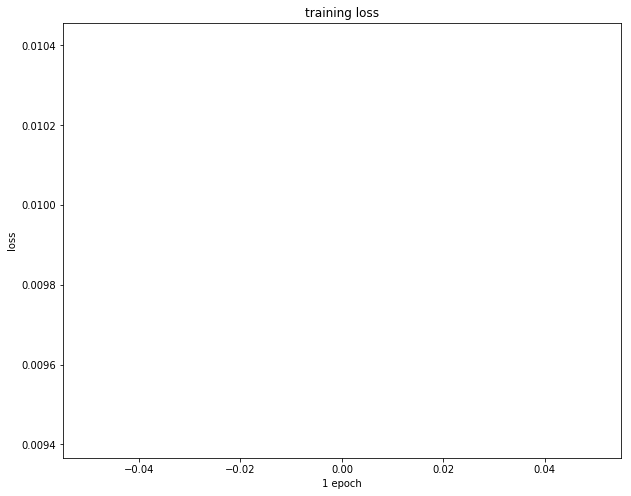

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
88s - loss: 0.0099 - acc: 0.0133 - val_loss: 0.0099 - val_acc: 0.0050


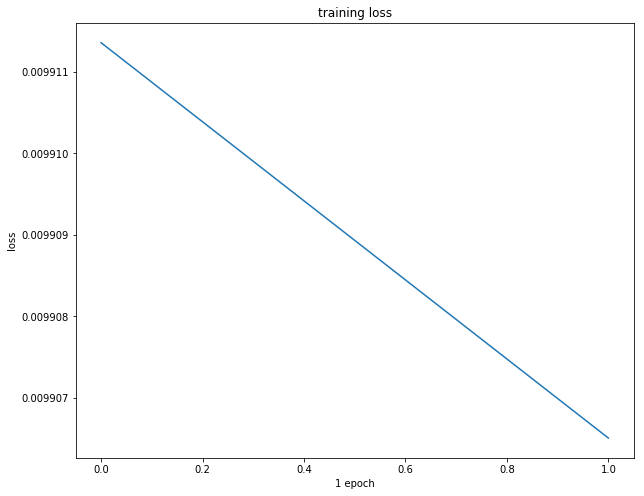

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0153 - val_loss: 0.0099 - val_acc: 0.0057


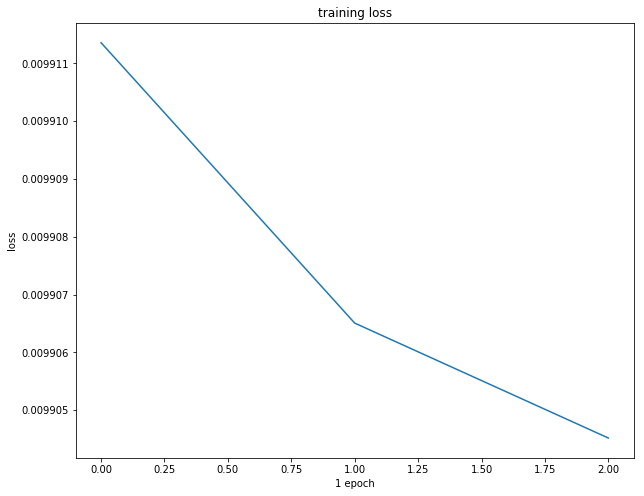

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0175 - val_loss: 0.0099 - val_acc: 0.0064


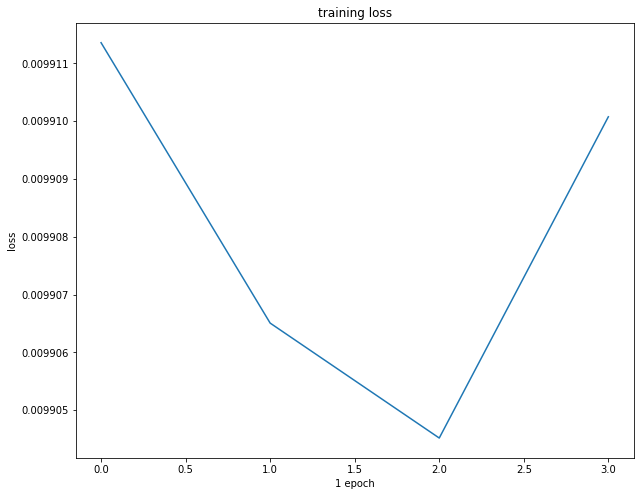

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0117 - val_loss: 0.0099 - val_acc: 0.0078


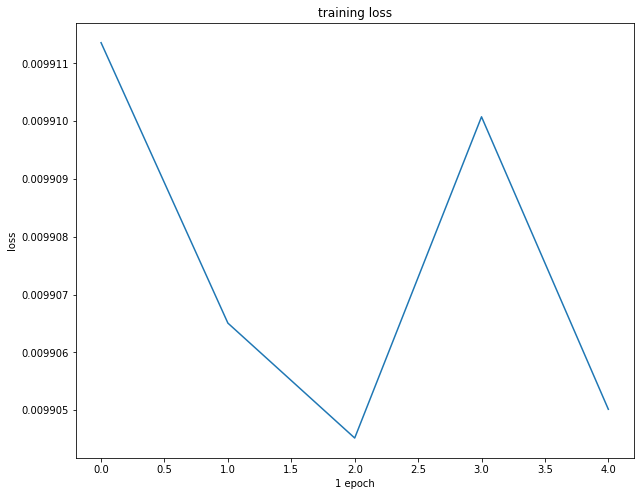

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
88s - loss: 0.0099 - acc: 0.0125 - val_loss: 0.0099 - val_acc: 0.0014


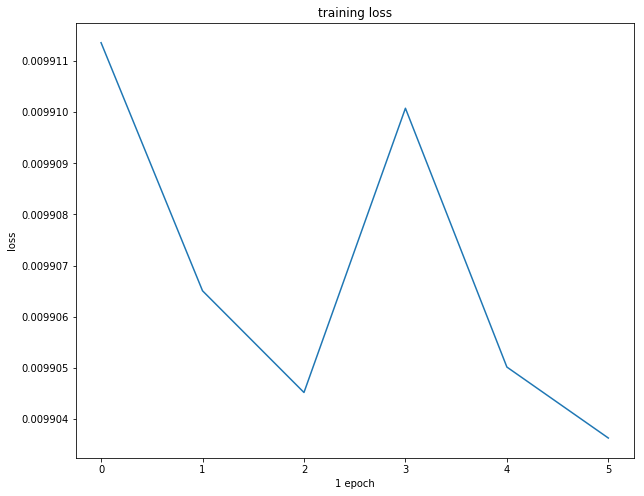

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
88s - loss: 0.0099 - acc: 0.0142 - val_loss: 0.0099 - val_acc: 0.0057


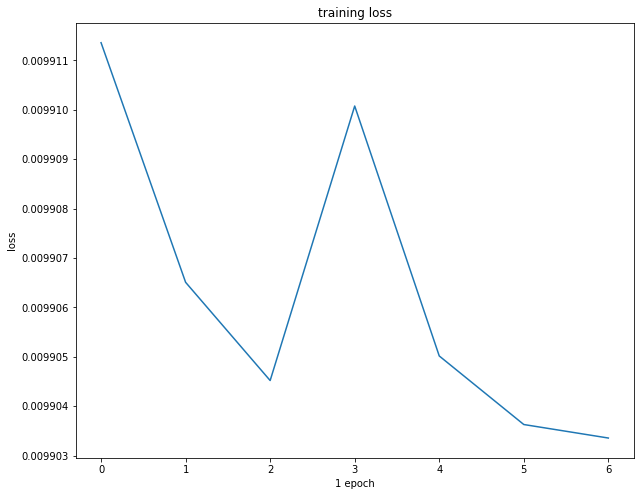

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0136 - val_loss: 0.0099 - val_acc: 0.0071


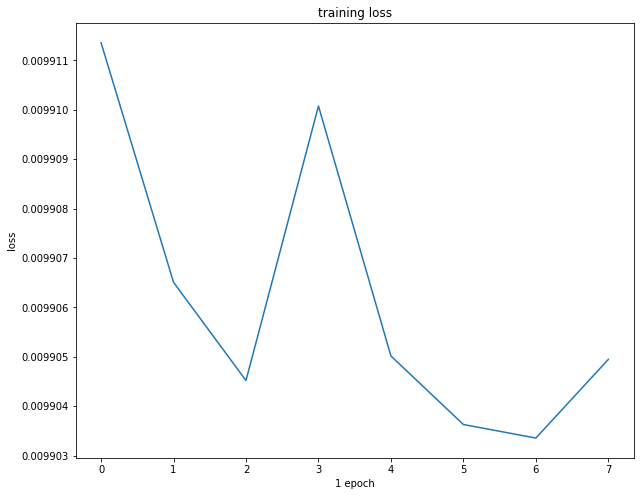

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0138 - val_loss: 0.0099 - val_acc: 0.0043


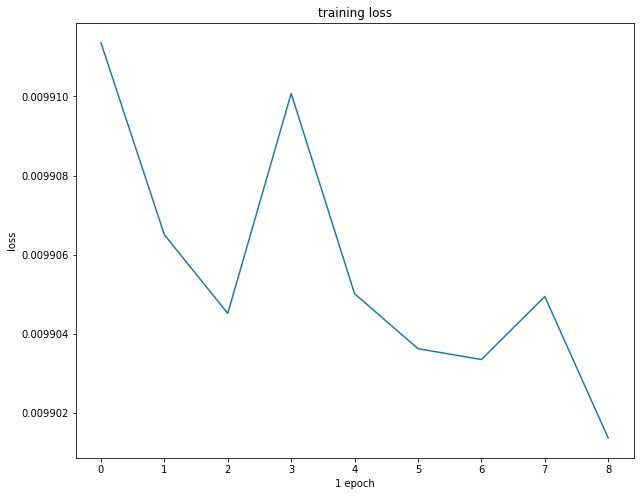

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0153 - val_loss: 0.0099 - val_acc: 0.0057


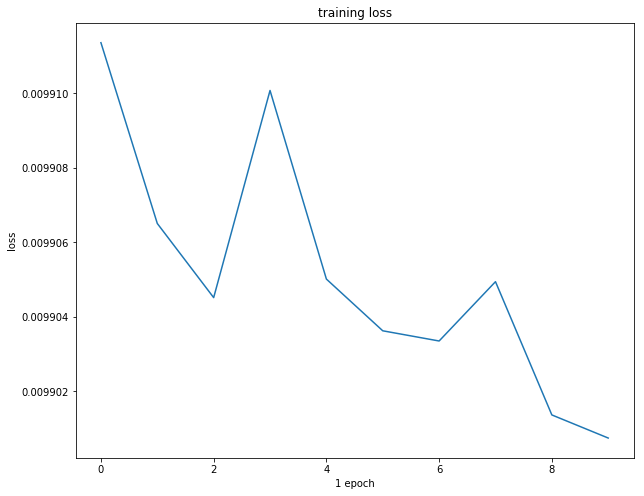

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0139 - val_loss: 0.0099 - val_acc: 0.0028


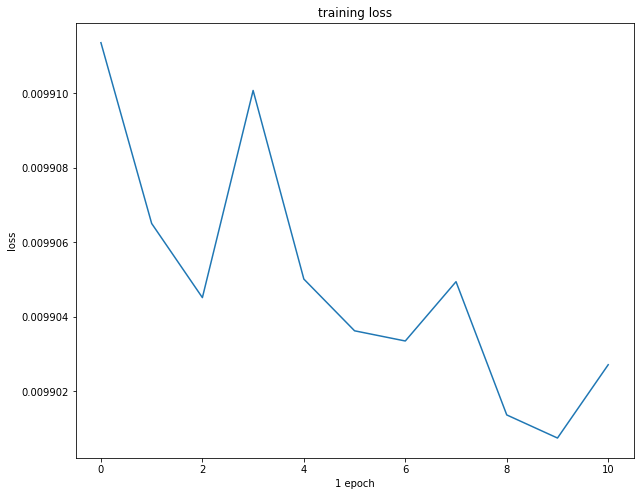

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0150 - val_loss: 0.0099 - val_acc: 0.0014


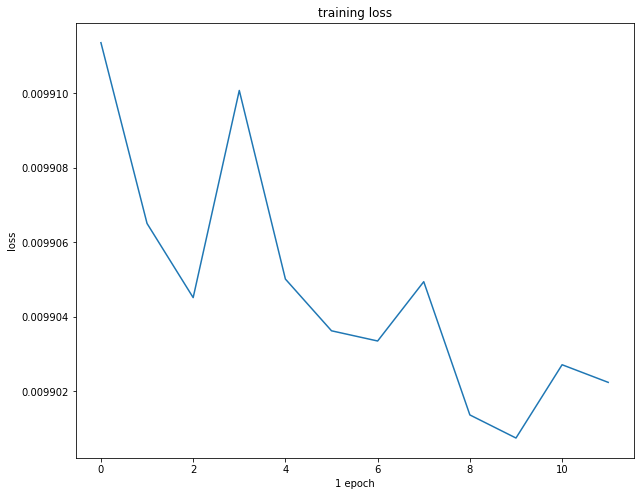

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
88s - loss: 0.0099 - acc: 0.0131 - val_loss: 0.0099 - val_acc: 0.0149


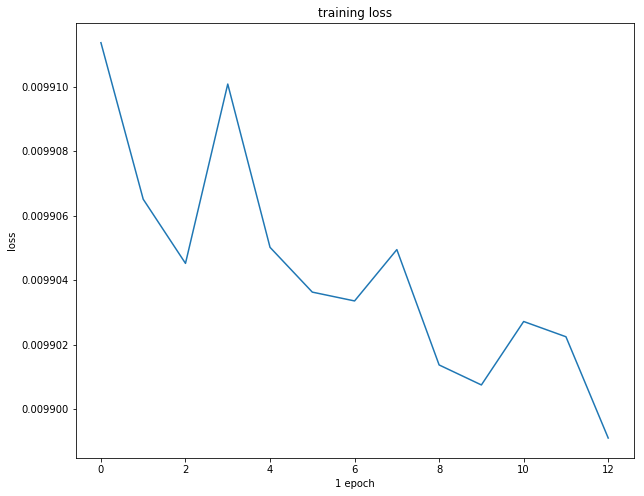

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0148 - val_loss: 0.0099 - val_acc: 0.0085


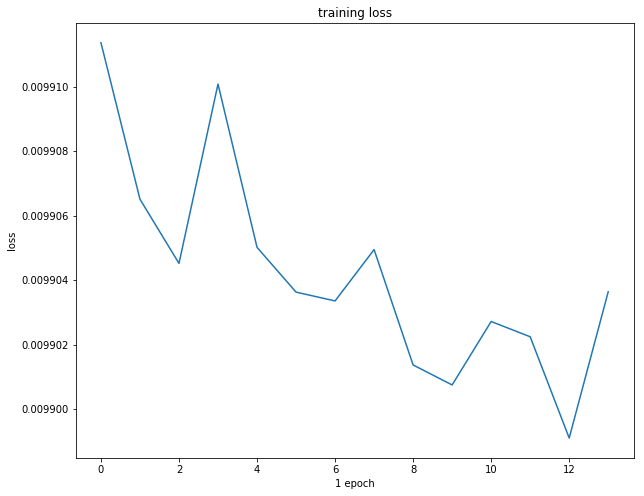

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0155 - val_loss: 0.0099 - val_acc: 0.0142


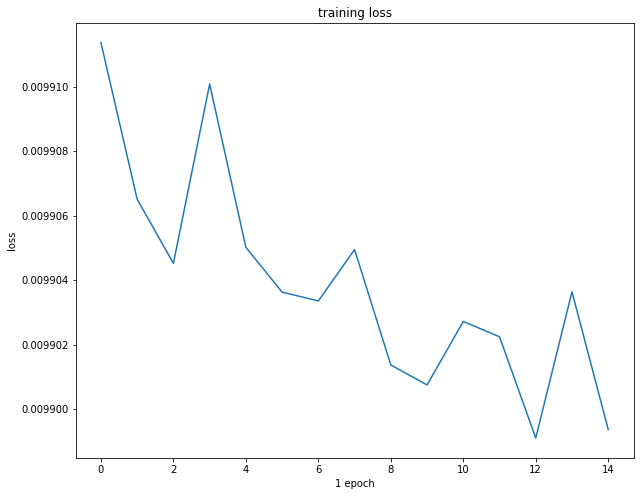

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0147 - val_loss: 0.0099 - val_acc: 0.0092


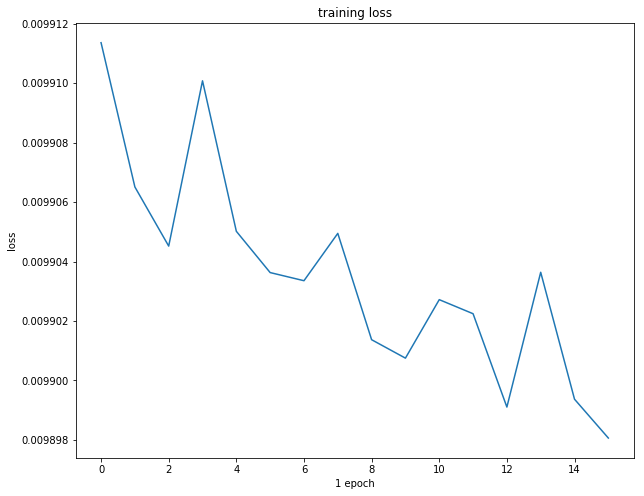

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0139 - val_loss: 0.0099 - val_acc: 7.1023e-04


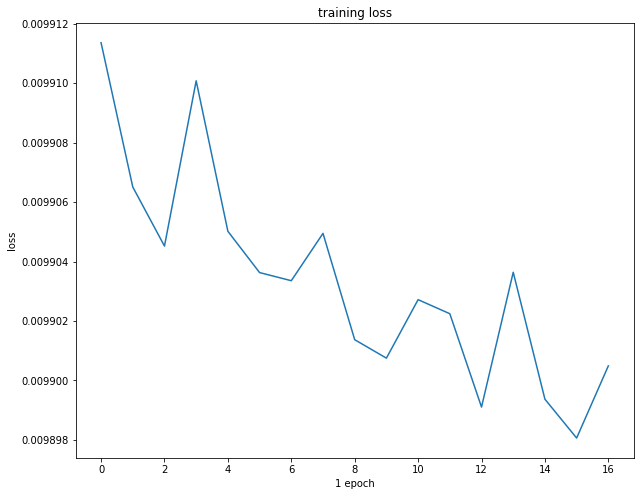

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
88s - loss: 0.0099 - acc: 0.0123 - val_loss: 0.0099 - val_acc: 0.0085


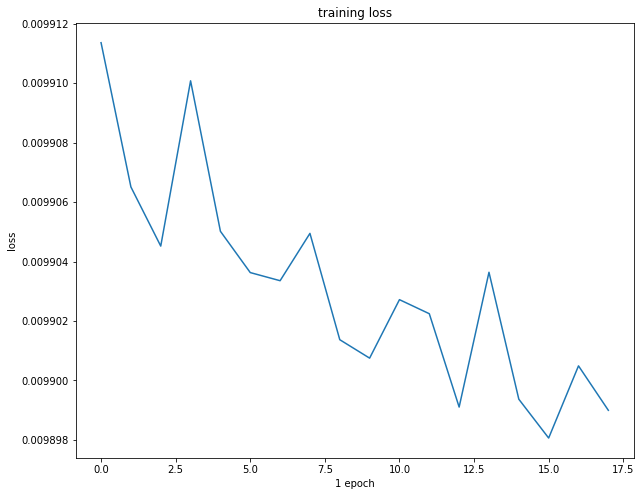

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
78s - loss: 0.0099 - acc: 0.0161 - val_loss: 0.0099 - val_acc: 0.0036


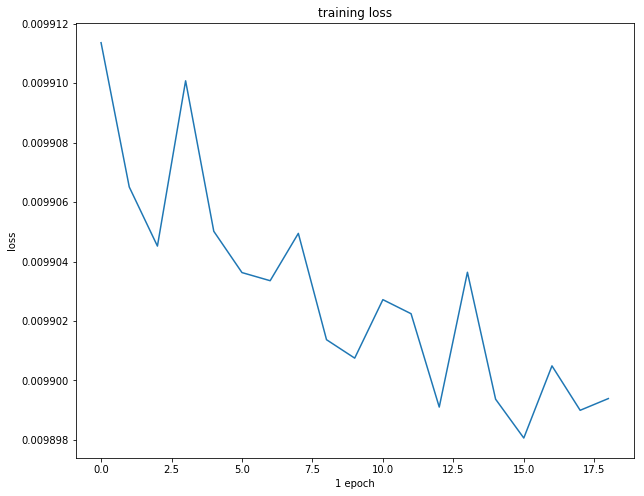

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0177 - val_loss: 0.0099 - val_acc: 0.0014


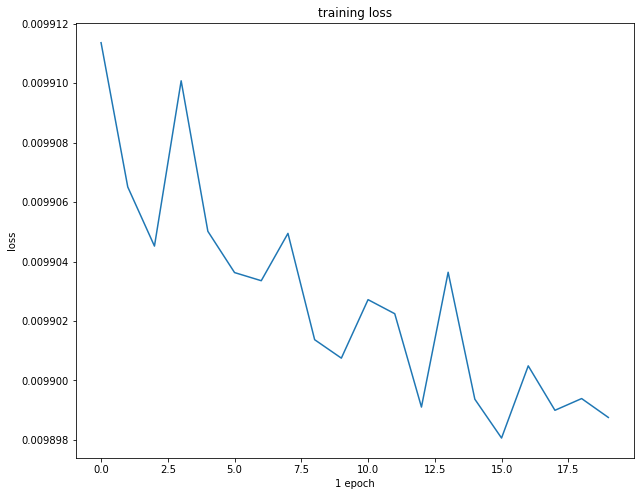

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0123 - val_loss: 0.0099 - val_acc: 0.0043


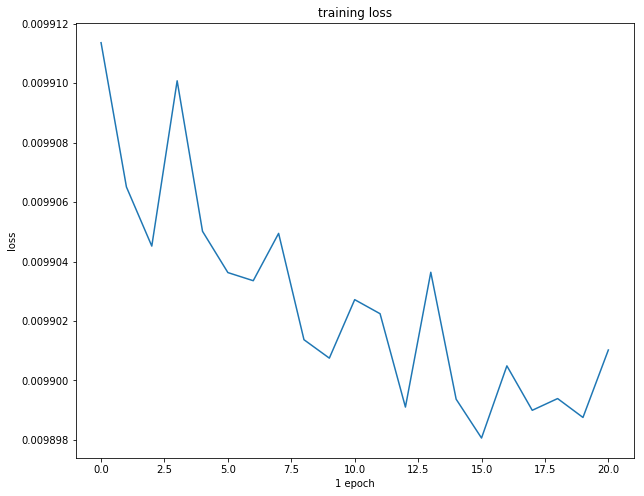

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0123 - val_loss: 0.0099 - val_acc: 0.0071


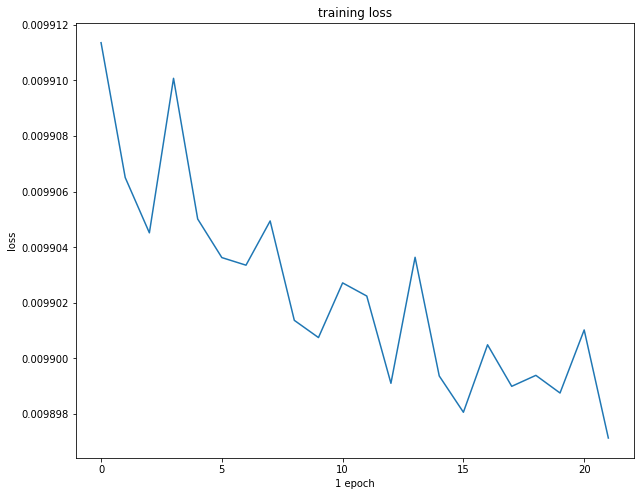

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0164 - val_loss: 0.0099 - val_acc: 0.0071


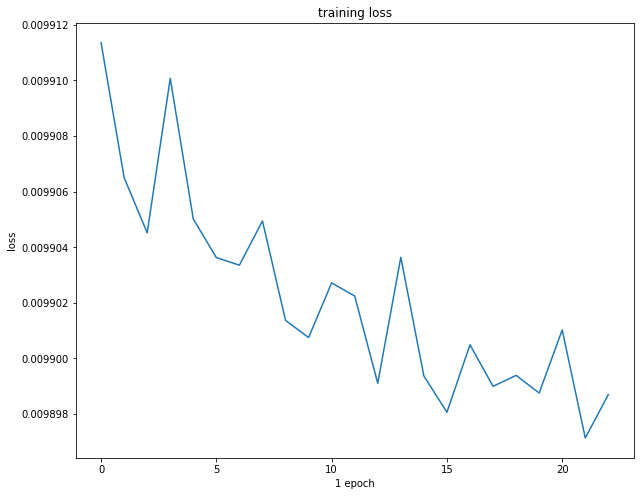

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0133 - val_loss: 0.0099 - val_acc: 0.0057


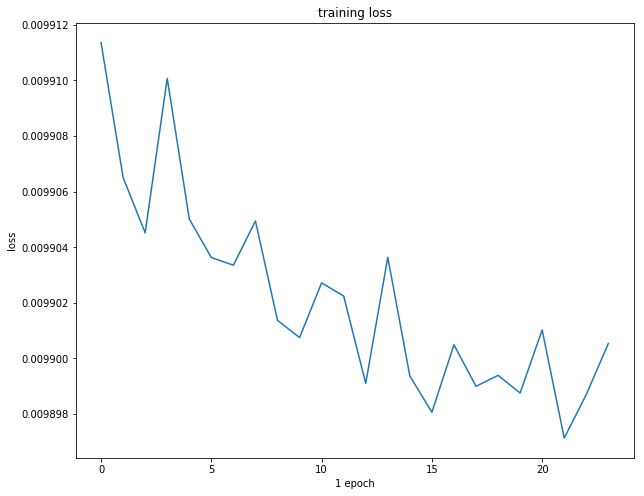

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0131 - val_loss: 0.0099 - val_acc: 0.0028


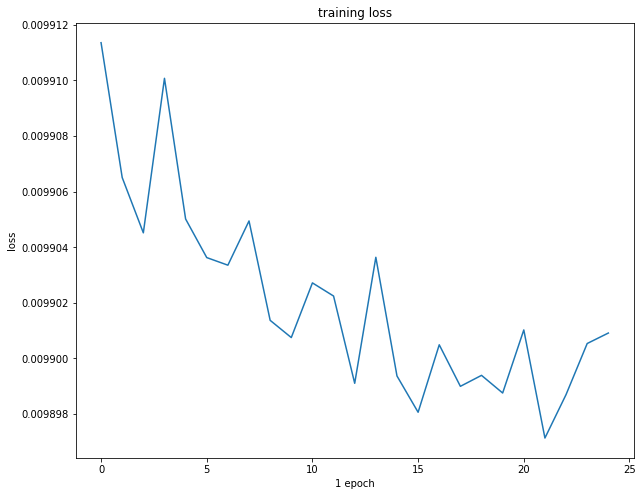

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0145 - val_loss: 0.0099 - val_acc: 0.0036


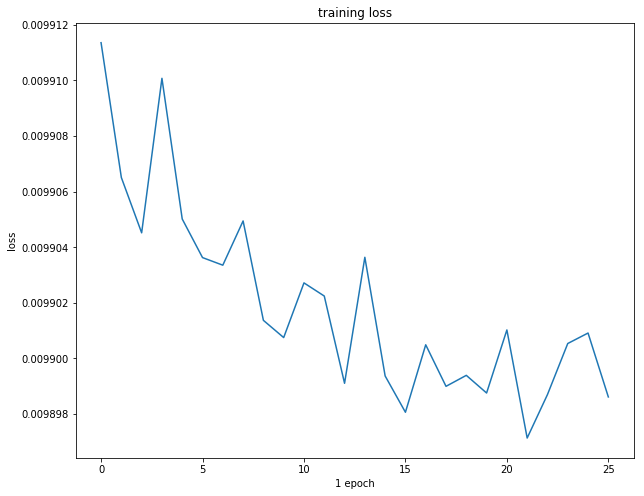

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0150 - val_loss: 0.0099 - val_acc: 0.0028


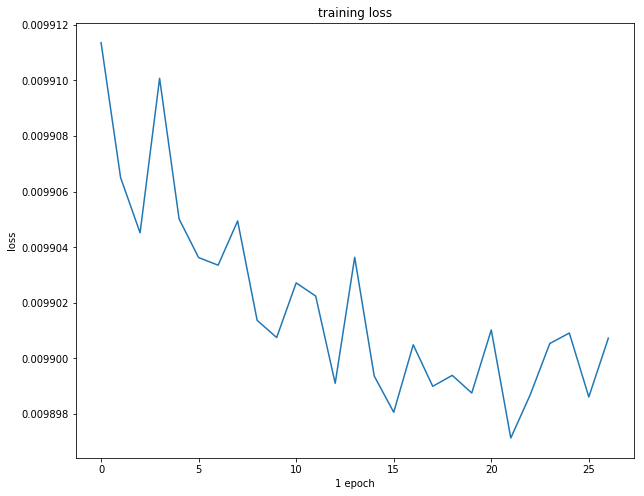

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0123 - val_loss: 0.0099 - val_acc: 0.0085


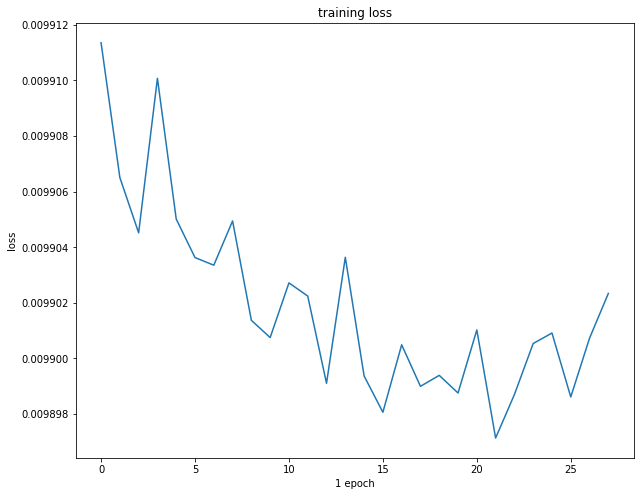

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0158 - val_loss: 0.0099 - val_acc: 0.0085


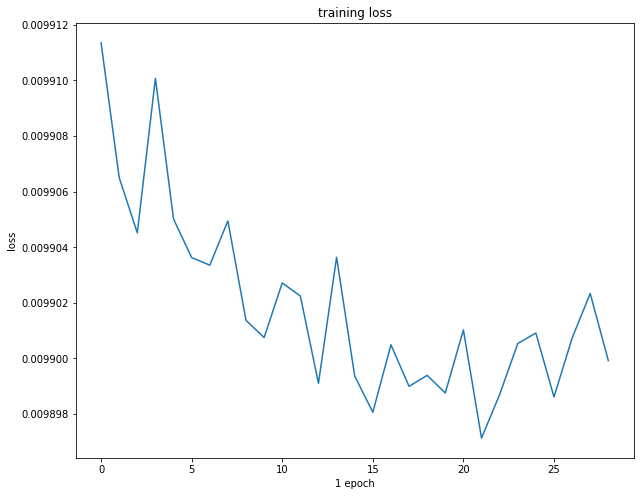

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0133 - val_loss: 0.0099 - val_acc: 0.0043


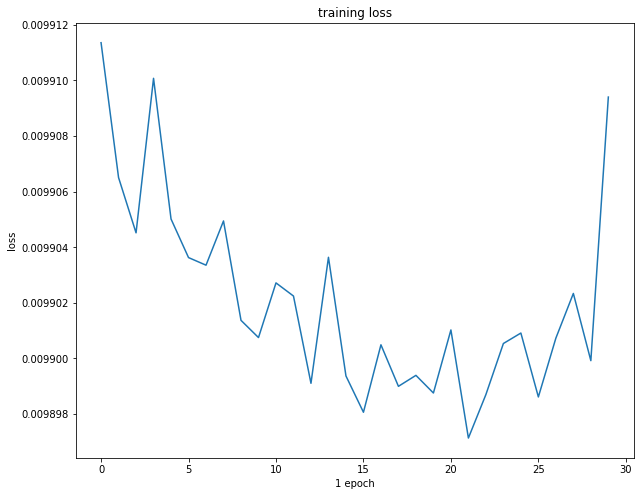

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0156 - val_loss: 0.0099 - val_acc: 0.0057


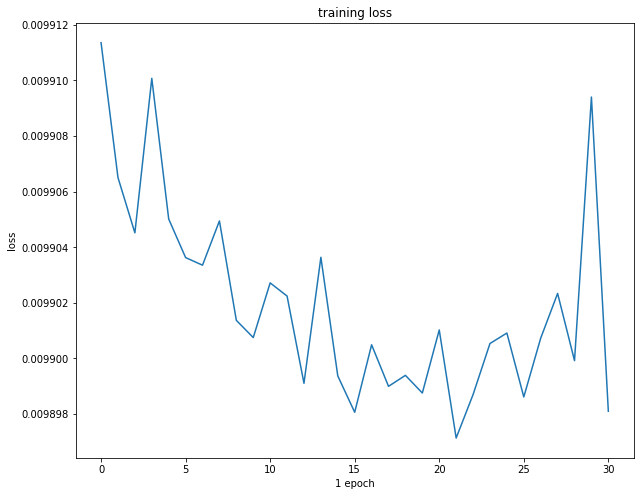

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0128 - val_loss: 0.0099 - val_acc: 0.0078


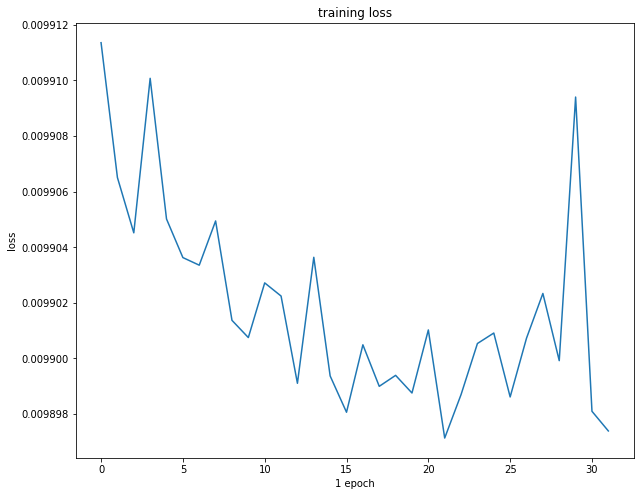

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0164 - val_loss: 0.0099 - val_acc: 7.1023e-04


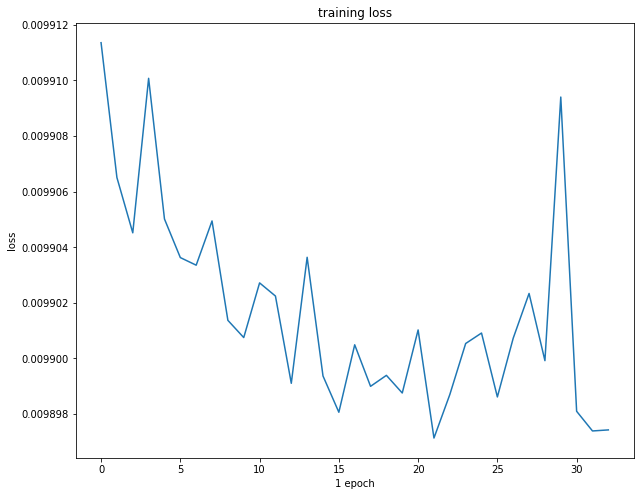

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0125 - val_loss: 0.0099 - val_acc: 0.0064


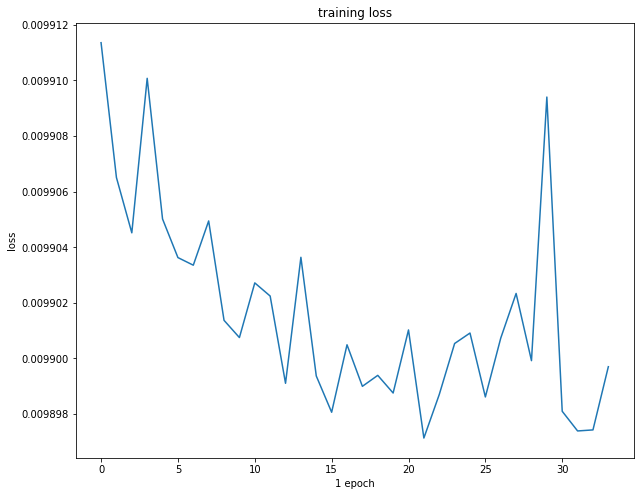

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0139 - val_loss: 0.0099 - val_acc: 0.0057


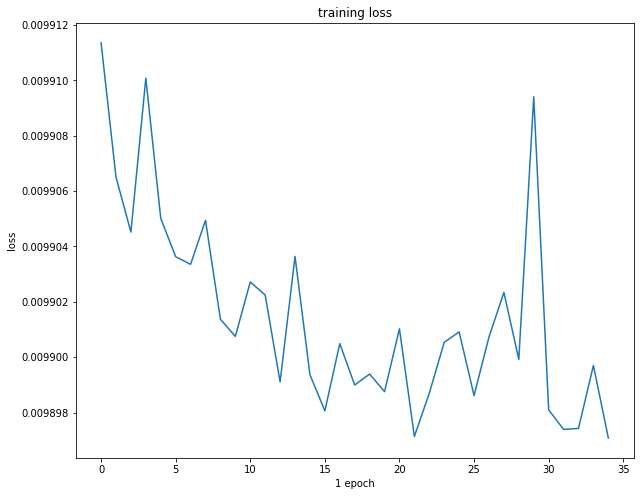

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0117 - val_loss: 0.0099 - val_acc: 0.0114


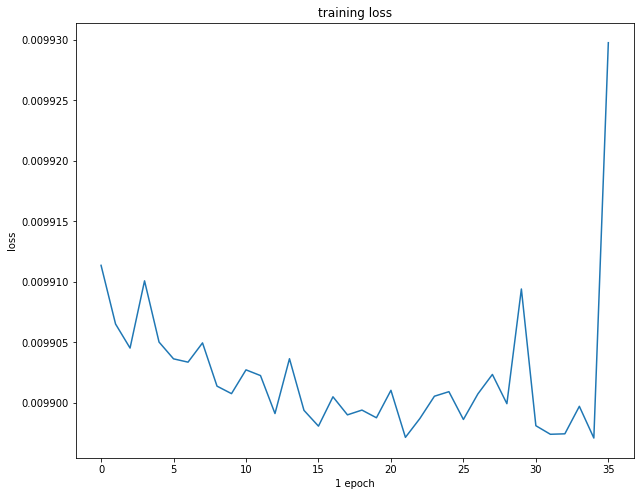

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0117 - val_loss: 0.0099 - val_acc: 0.0021


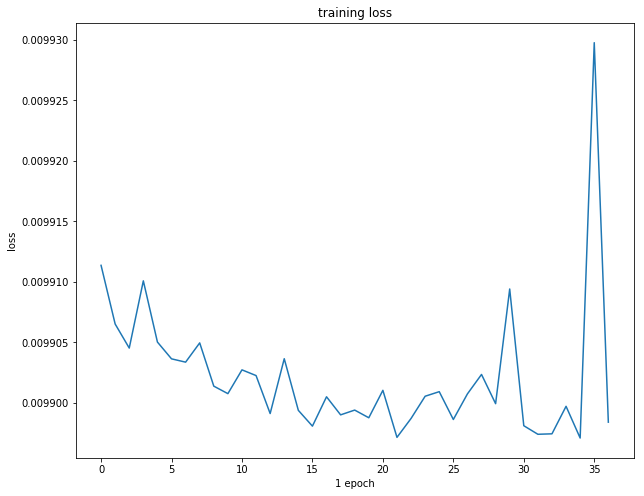

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0153 - val_loss: 0.0099 - val_acc: 0.0135


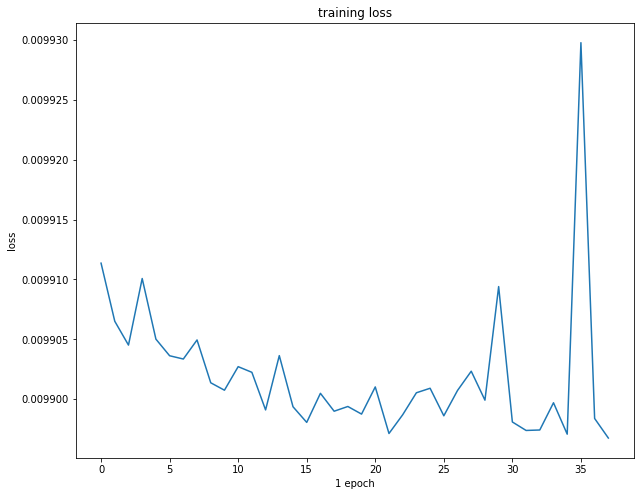

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0130 - val_loss: 0.0099 - val_acc: 0.0071


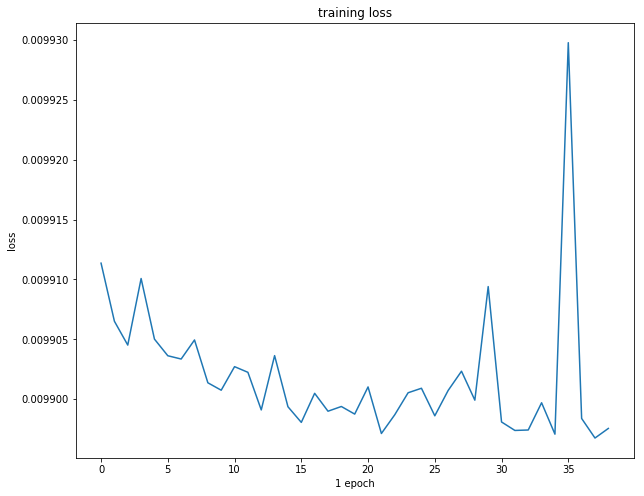

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0120 - val_loss: 0.0099 - val_acc: 0.0021


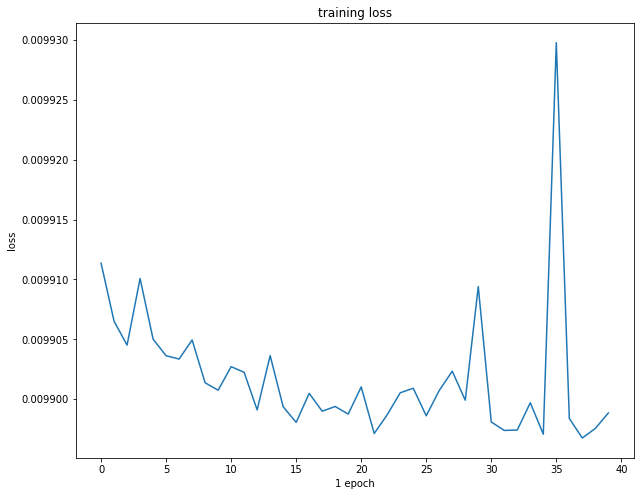

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0155 - val_loss: 0.0099 - val_acc: 0.0036


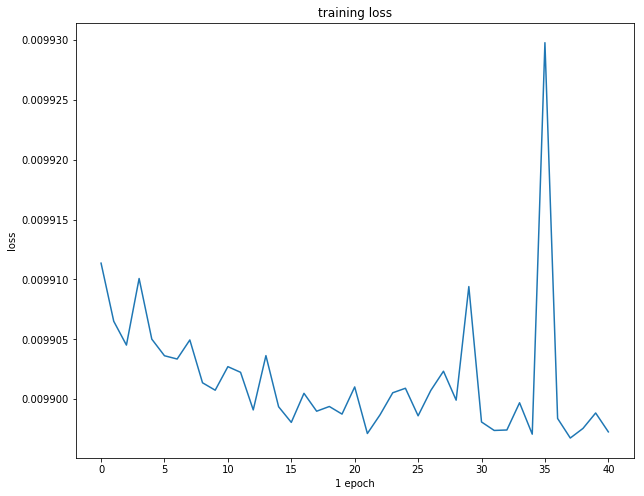

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0170 - val_loss: 0.0099 - val_acc: 0.0043


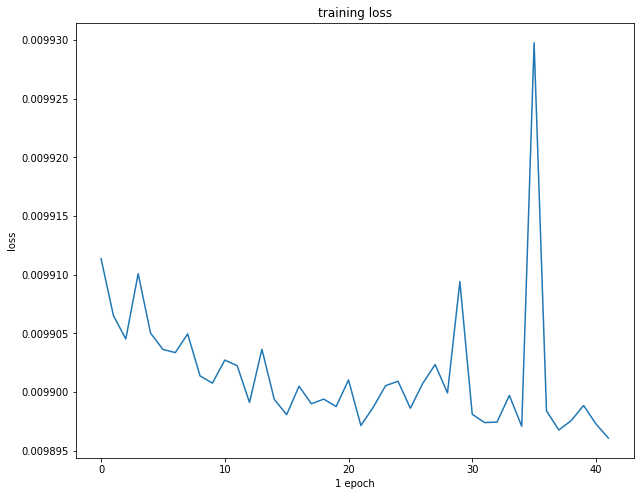

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0138 - val_loss: 0.0099 - val_acc: 0.0064


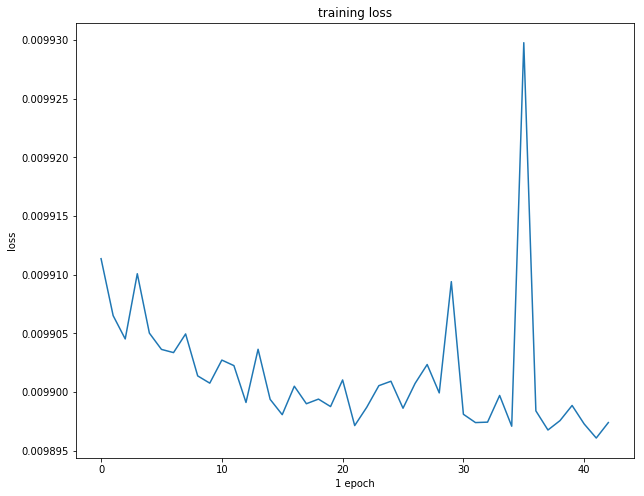

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0155 - val_loss: 0.0099 - val_acc: 0.0057


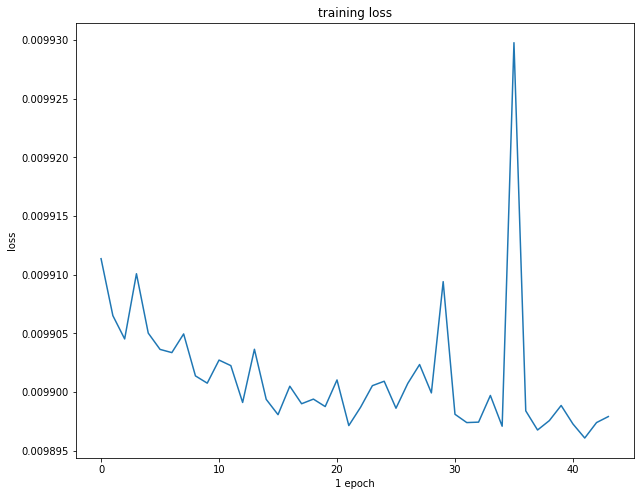

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0147 - val_loss: 0.0099 - val_acc: 0.0071


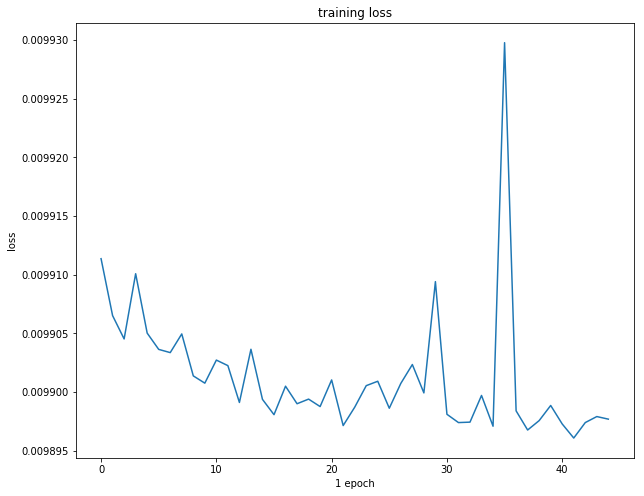

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0194 - val_loss: 0.0099 - val_acc: 0.0085


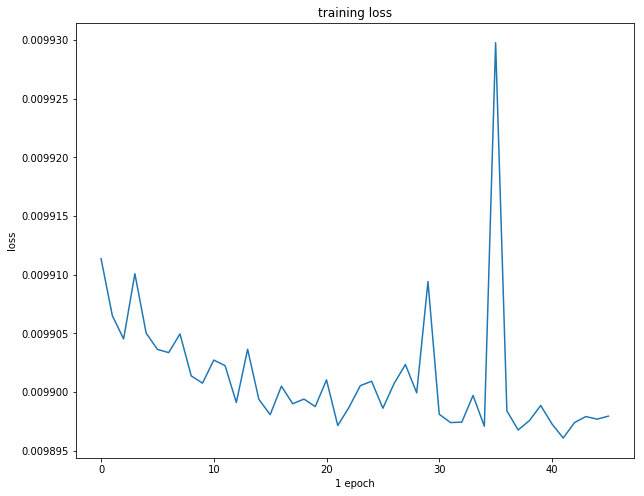

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0186 - val_loss: 0.0099 - val_acc: 0.0021


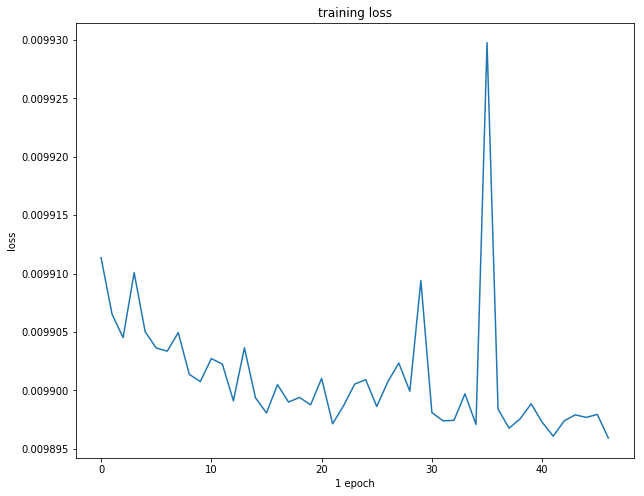

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0145 - val_loss: 0.0099 - val_acc: 7.1023e-04


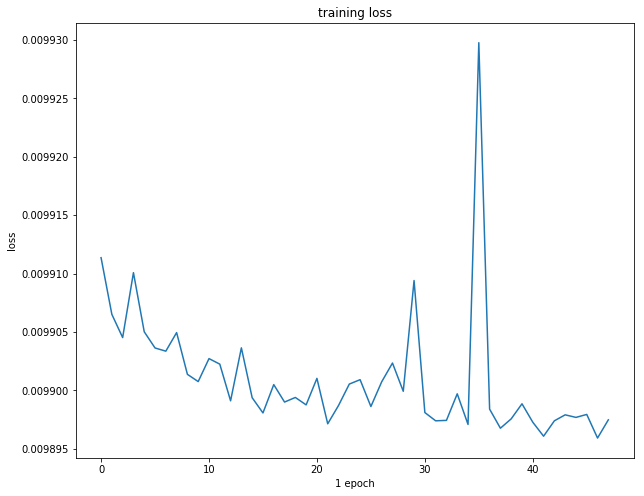

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0166 - val_loss: 0.0099 - val_acc: 0.0028


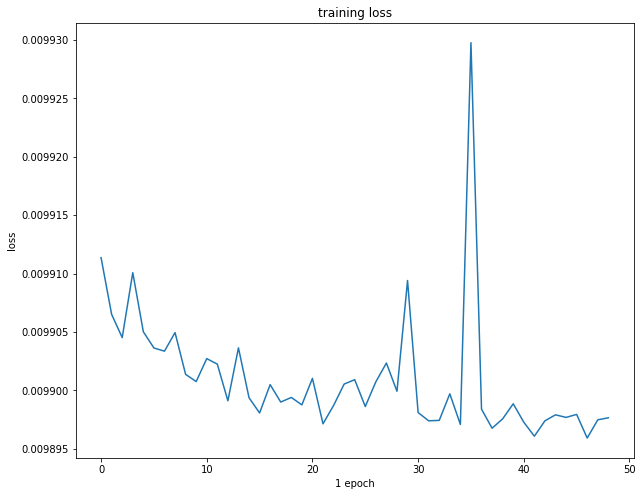

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0144 - val_loss: 0.0099 - val_acc: 0.0064


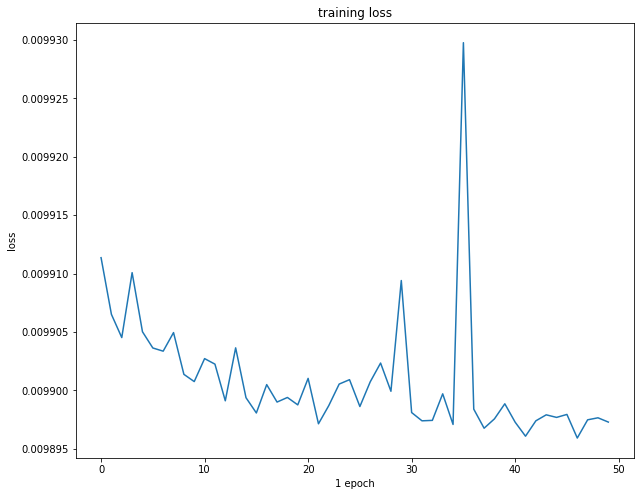

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0123 - val_loss: 0.0099 - val_acc: 0.0028


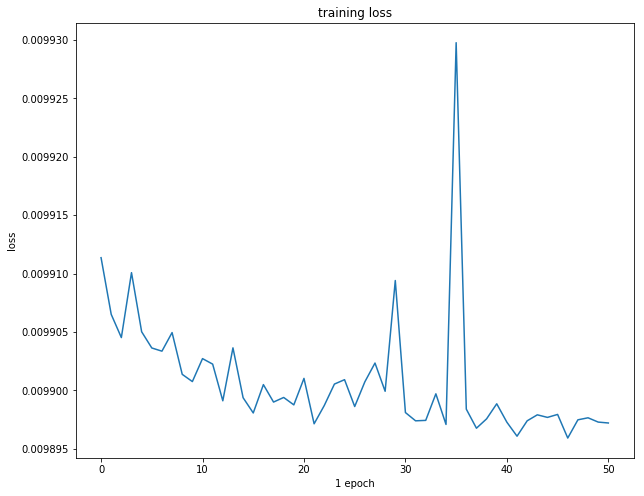

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0119 - val_loss: 0.0099 - val_acc: 0.0099


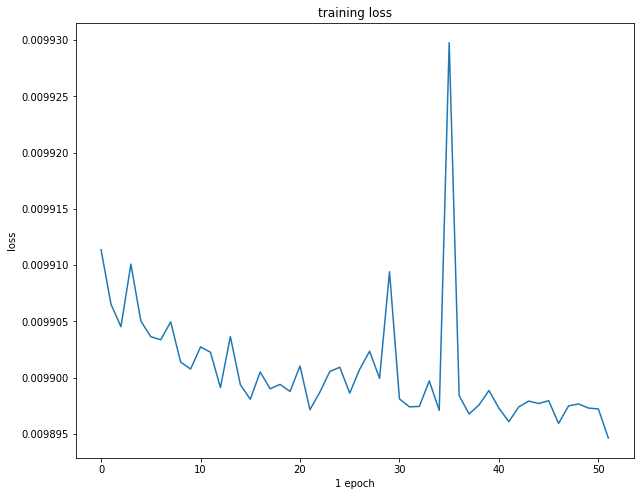

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0175 - val_loss: 0.0099 - val_acc: 0.0078


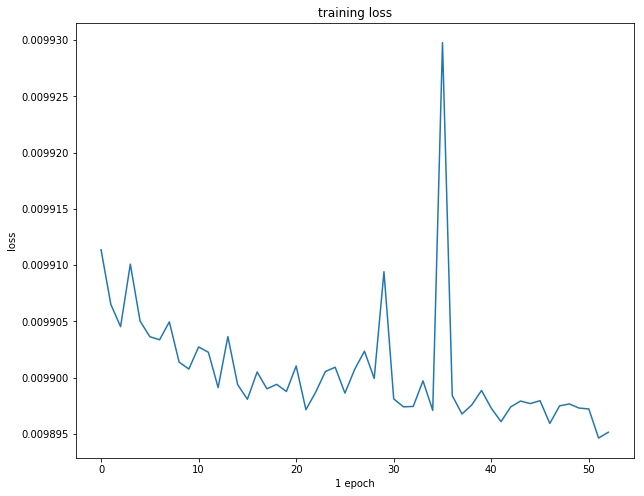

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0152 - val_loss: 0.0099 - val_acc: 0.0057


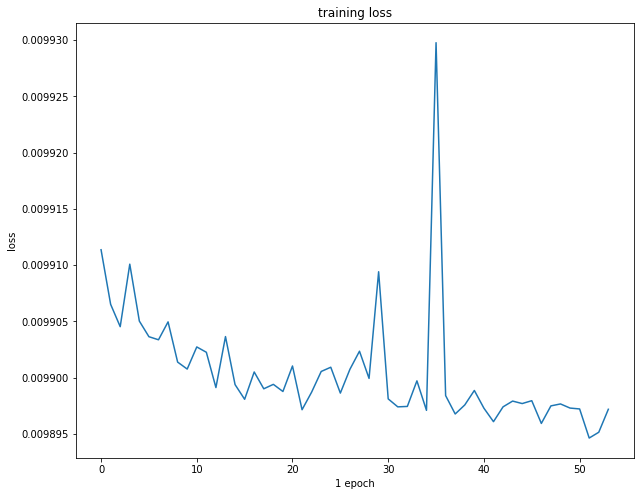

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0119 - val_loss: 0.0099 - val_acc: 0.0078


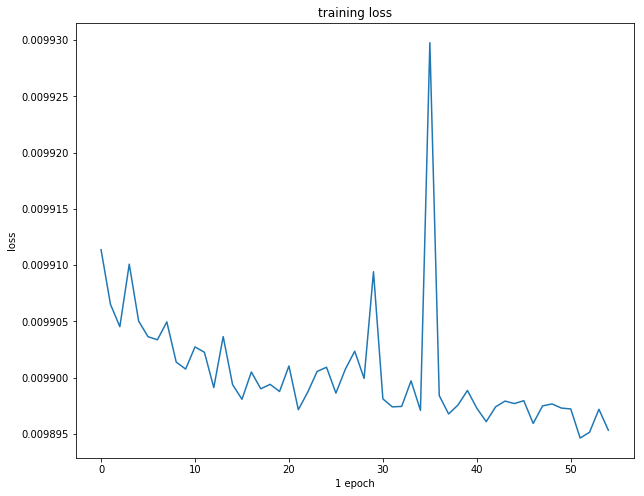

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0167 - val_loss: 0.0099 - val_acc: 0.0021


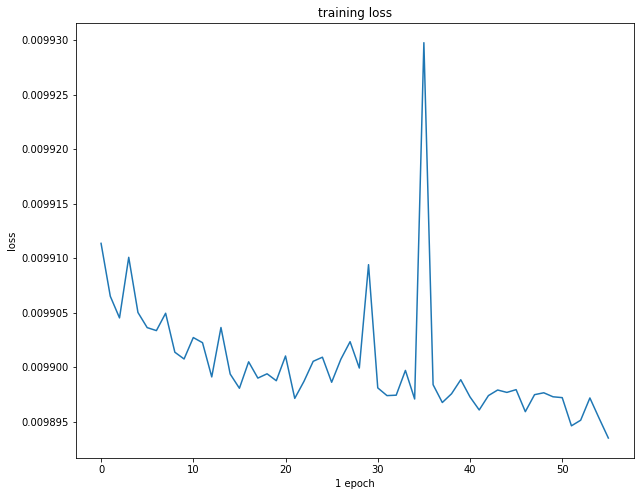

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0127 - val_loss: 0.0099 - val_acc: 0.0036


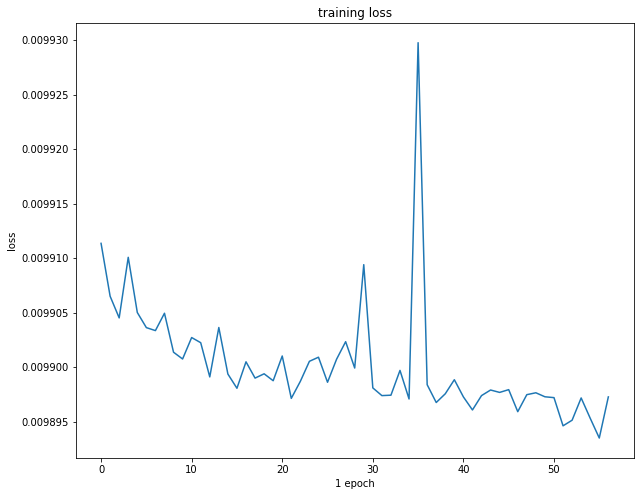

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0147 - val_loss: 0.0099 - val_acc: 0.0185


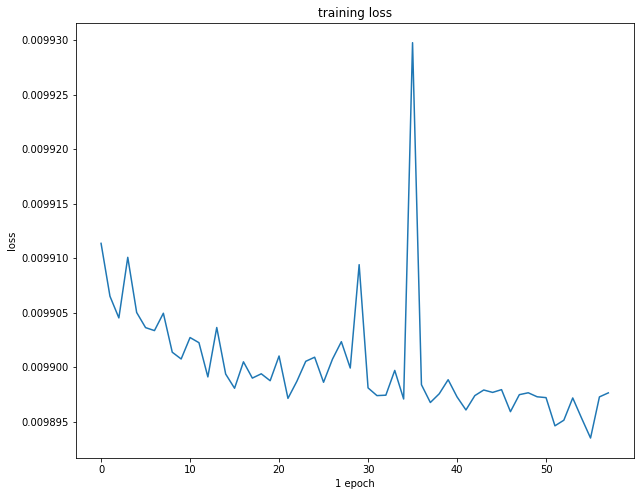

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0141 - val_loss: 0.0099 - val_acc: 0.0092


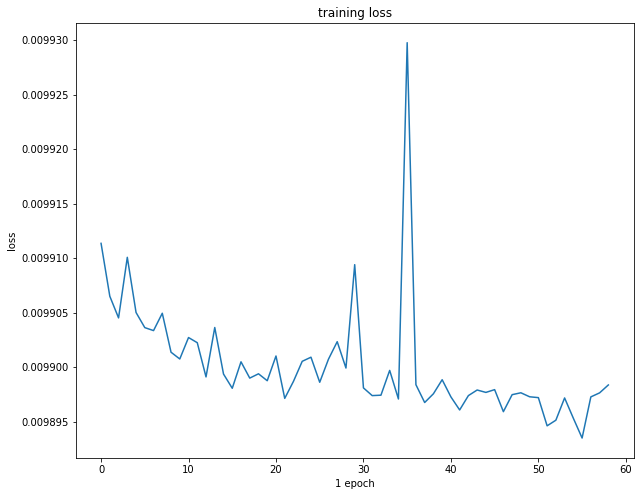

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0148 - val_loss: 0.0099 - val_acc: 0.0036


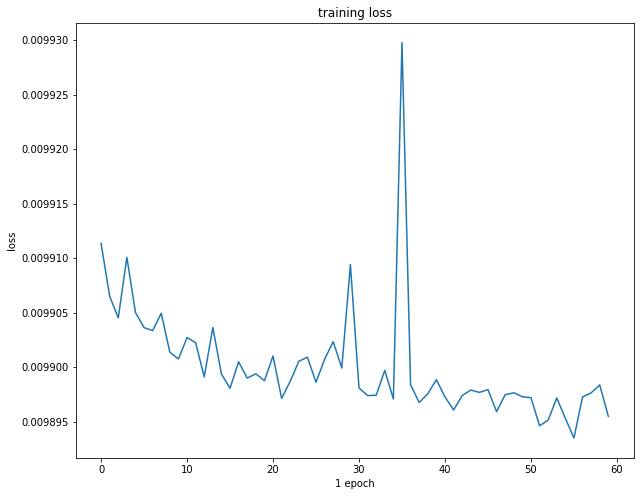

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0153 - val_loss: 0.0099 - val_acc: 0.0092


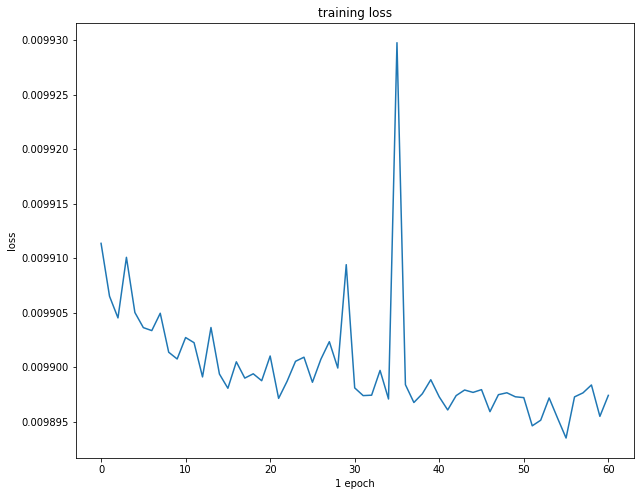

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0120 - val_loss: 0.0099 - val_acc: 0.0135


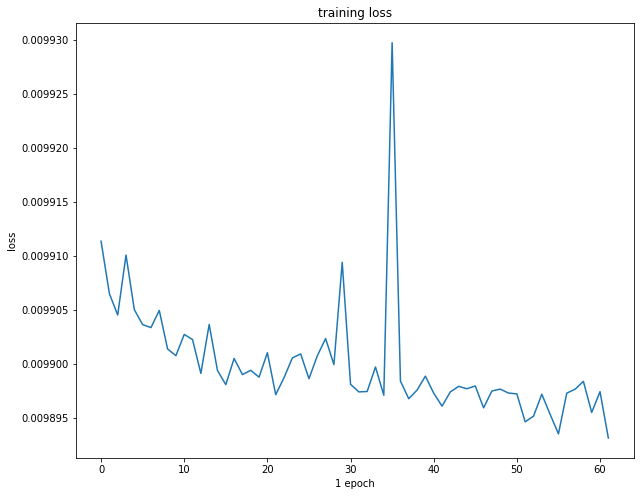

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0170 - val_loss: 0.0099 - val_acc: 0.0043


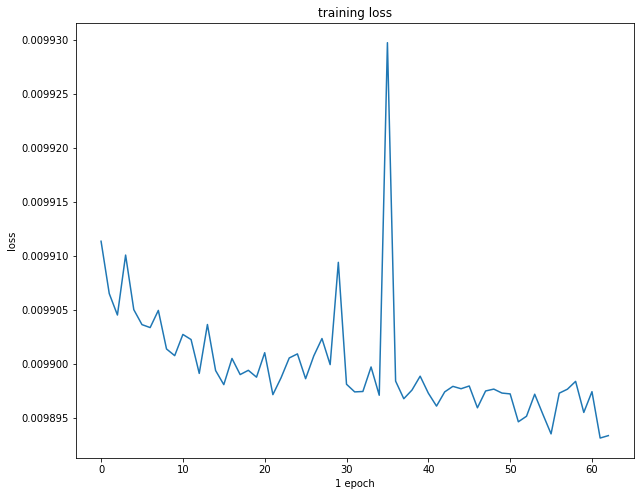

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0166 - val_loss: 0.0099 - val_acc: 0.0043


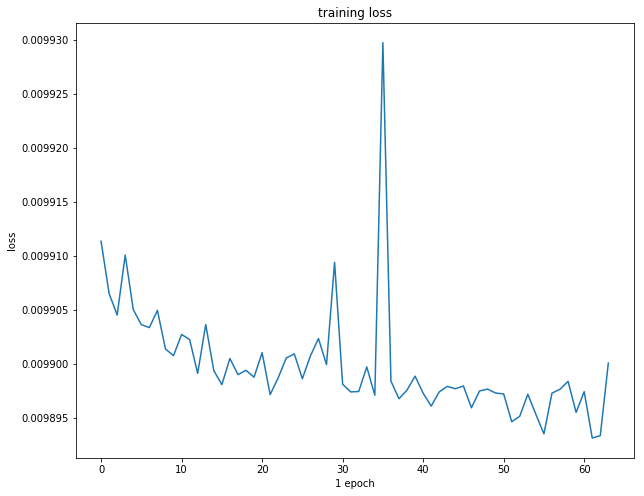

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0159 - val_loss: 0.0099 - val_acc: 0.0021


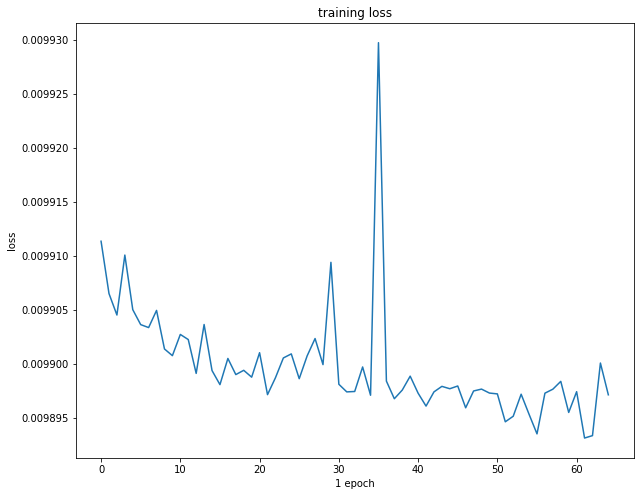

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0136 - val_loss: 0.0099 - val_acc: 0.0057


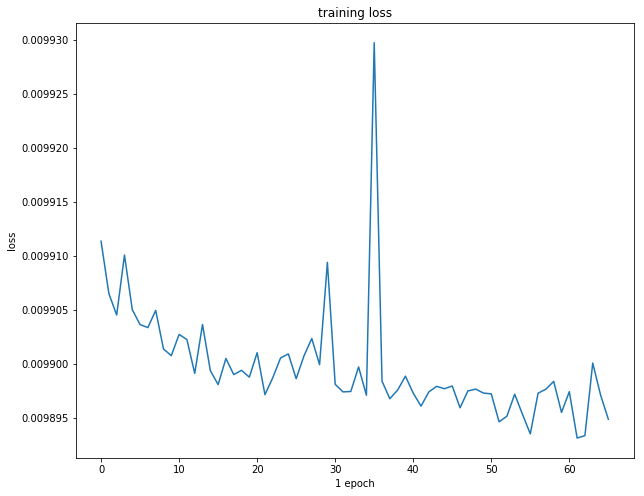

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0131 - val_loss: 0.0099 - val_acc: 0.0092


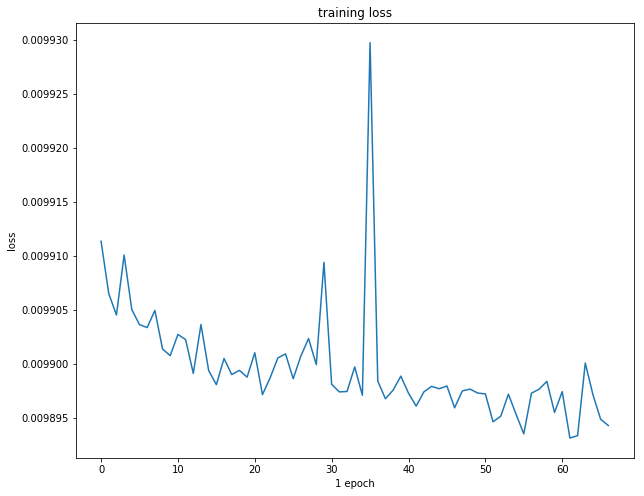

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0158 - val_loss: 0.0099 - val_acc: 0.0092


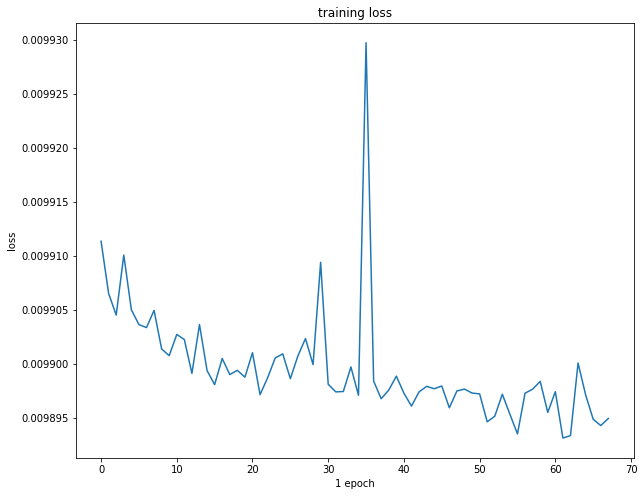

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0166 - val_loss: 0.0099 - val_acc: 0.0114


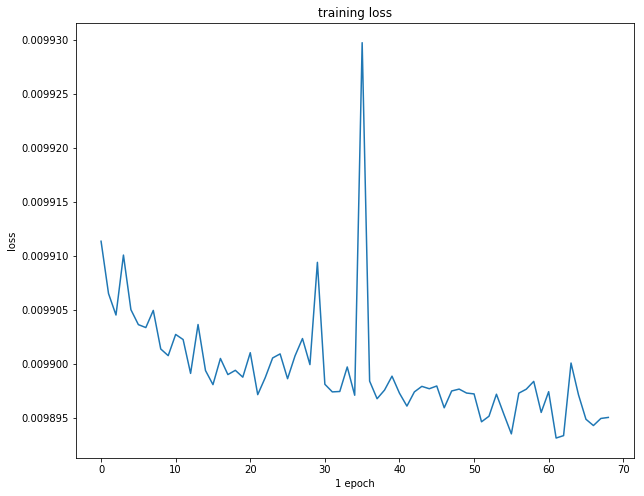

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0134 - val_loss: 0.0099 - val_acc: 0.0043


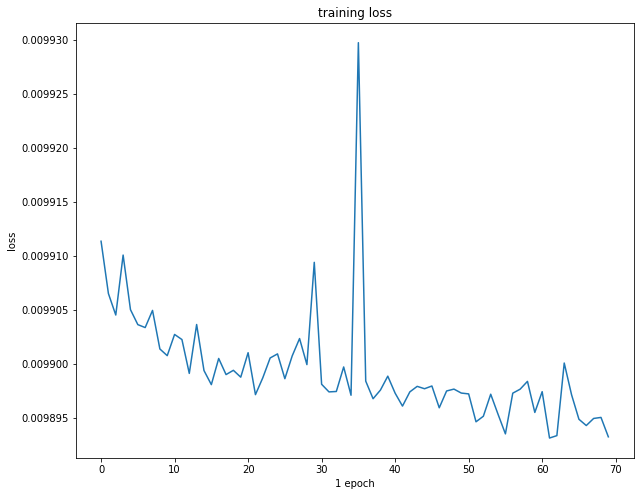

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0123 - val_loss: 0.0099 - val_acc: 0.0071


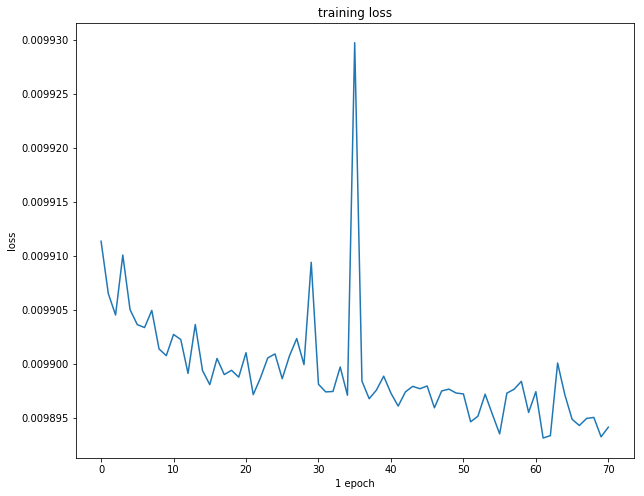

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0144 - val_loss: 0.0099 - val_acc: 0.0014


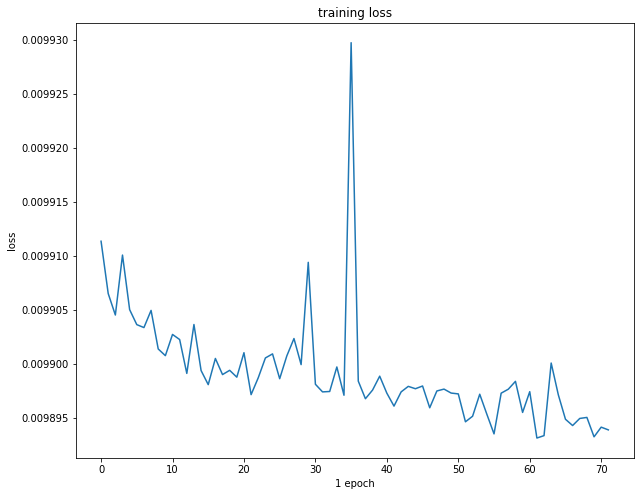

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0148 - val_loss: 0.0099 - val_acc: 0.0043


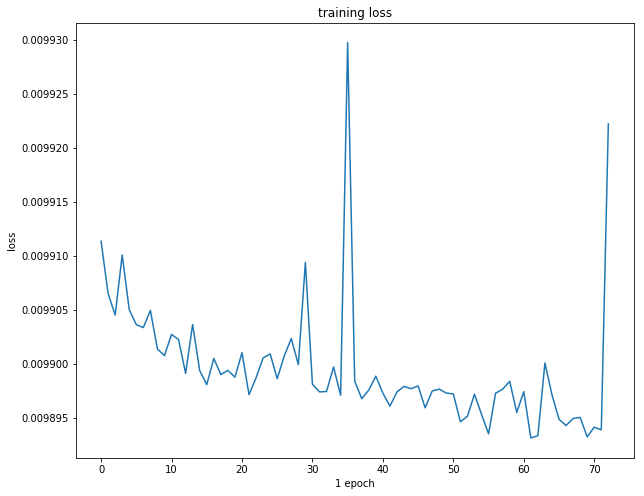

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0148 - val_loss: 0.0099 - val_acc: 0.0078


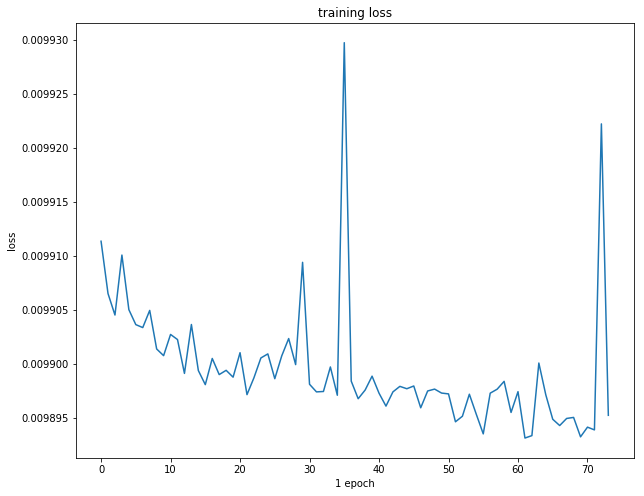

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0138 - val_loss: 0.0099 - val_acc: 0.0043


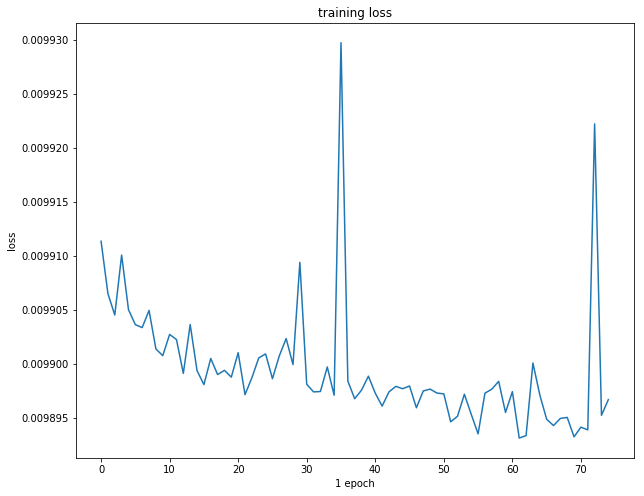

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0153 - val_loss: 0.0099 - val_acc: 0.0036


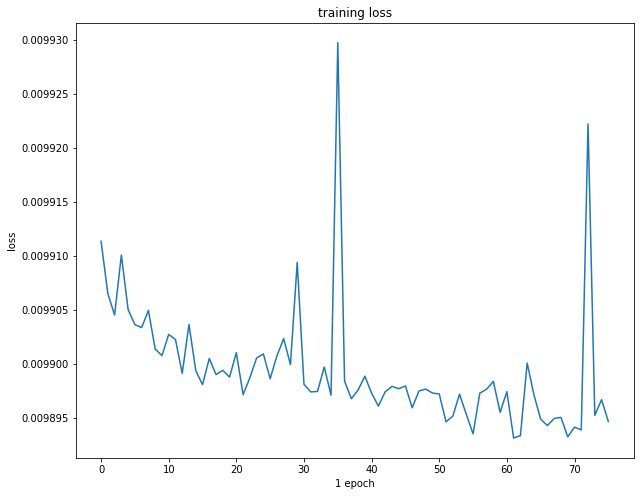

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0167 - val_loss: 0.0099 - val_acc: 0.0028


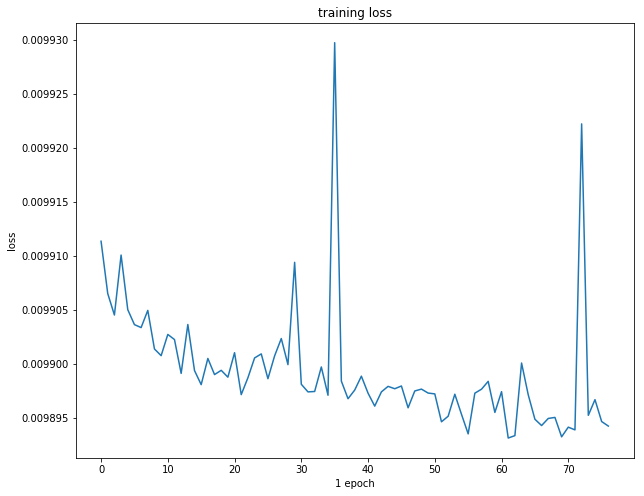

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0128 - val_loss: 0.0099 - val_acc: 0.0085


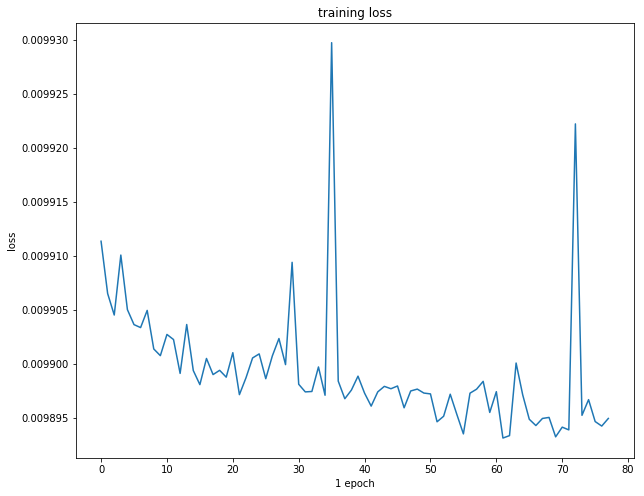

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0138 - val_loss: 0.0099 - val_acc: 0.0057


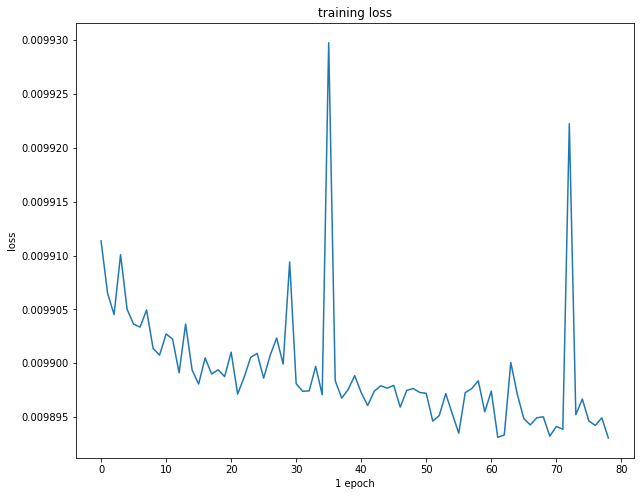

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0163 - val_loss: 0.0099 - val_acc: 7.1023e-04


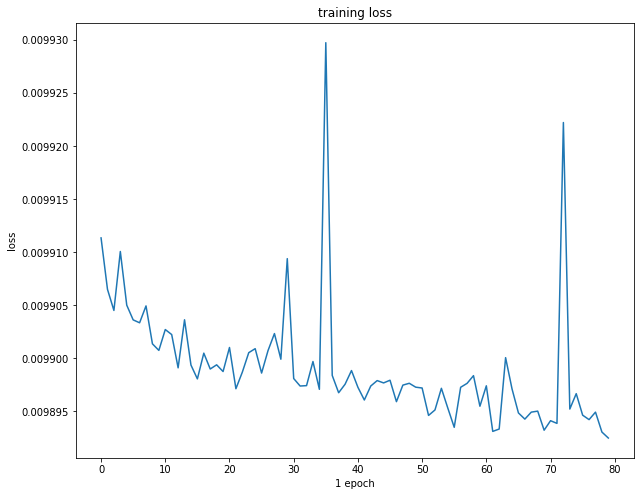

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0153 - val_loss: 0.0099 - val_acc: 0.0071


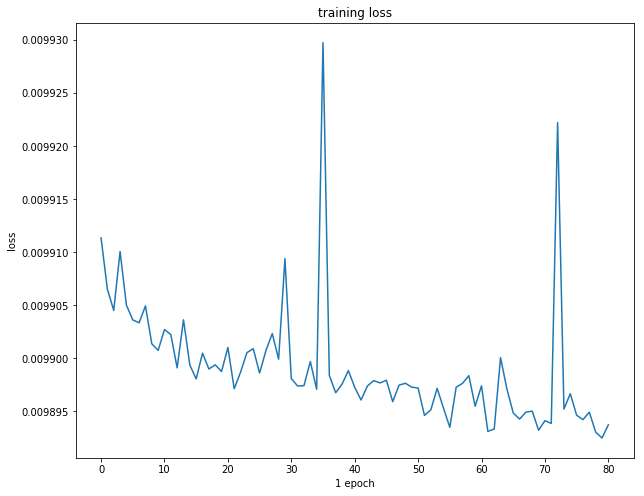

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0166 - val_loss: 0.0099 - val_acc: 0.0014


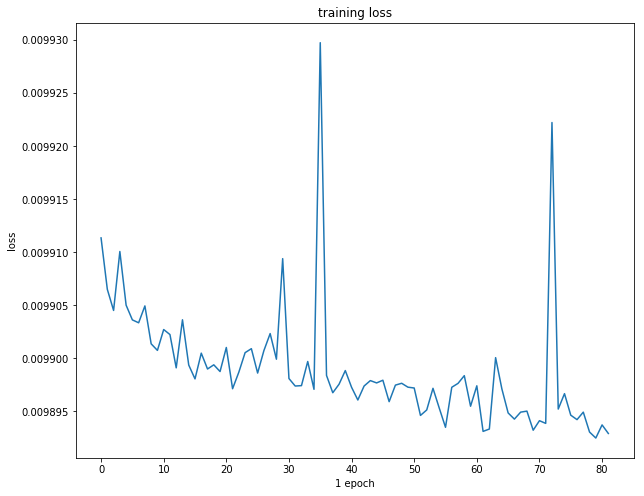

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0187 - val_loss: 0.0099 - val_acc: 0.0050


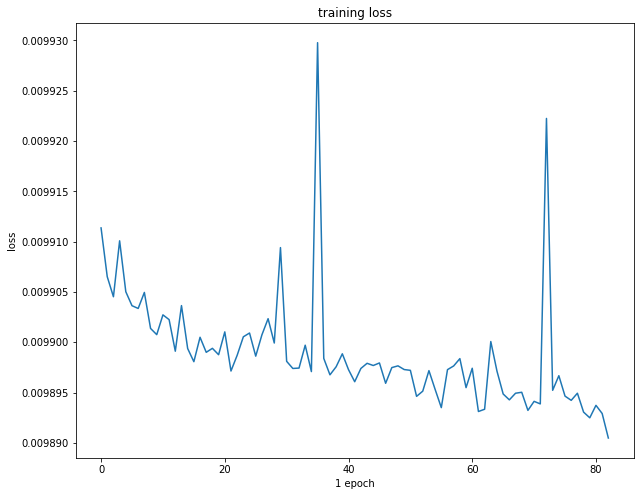

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0144 - val_loss: 0.0099 - val_acc: 0.0036


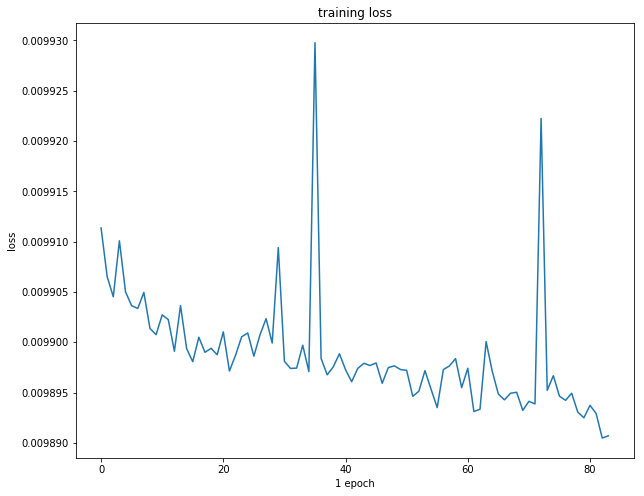

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0119 - val_loss: 0.0099 - val_acc: 0.0071


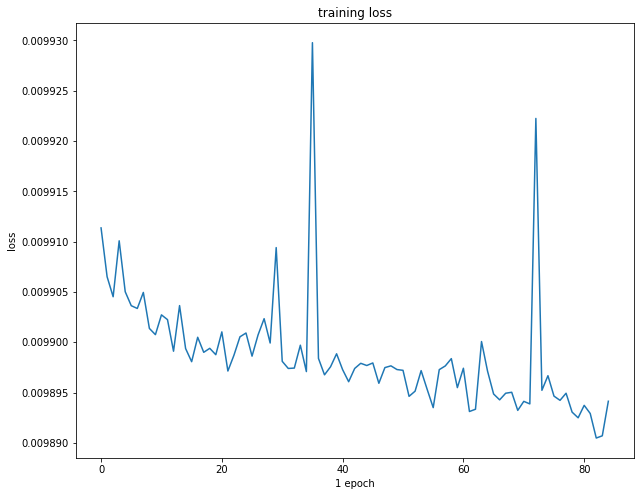

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0152 - val_loss: 0.0099 - val_acc: 0.0057


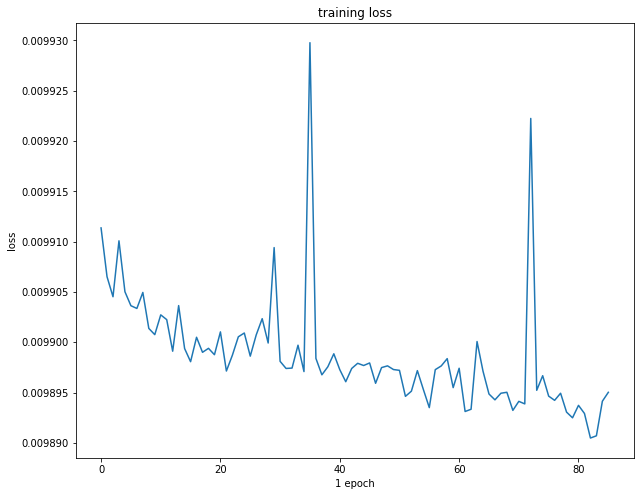

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0172 - val_loss: 0.0099 - val_acc: 0.0050


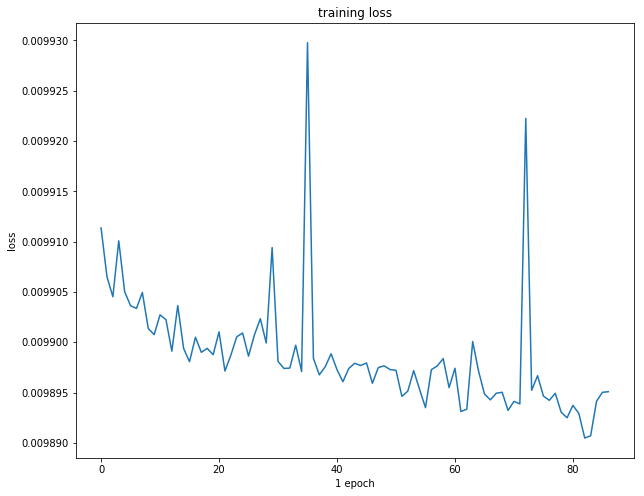

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0153 - val_loss: 0.0099 - val_acc: 0.0071


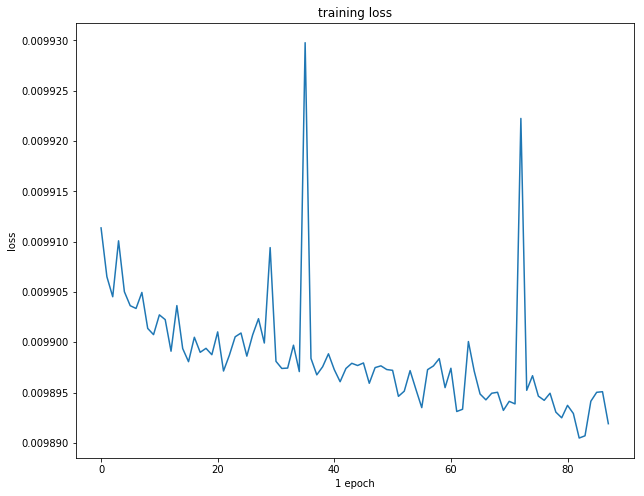

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0100 - acc: 0.0177 - val_loss: 0.0099 - val_acc: 0.0014


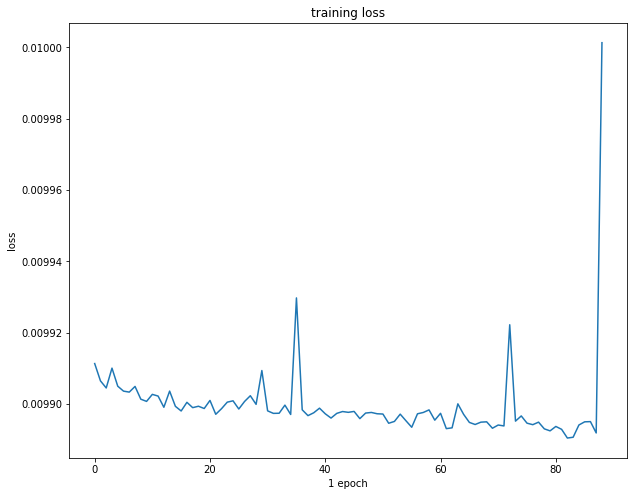

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0158 - val_loss: 0.0099 - val_acc: 0.0021


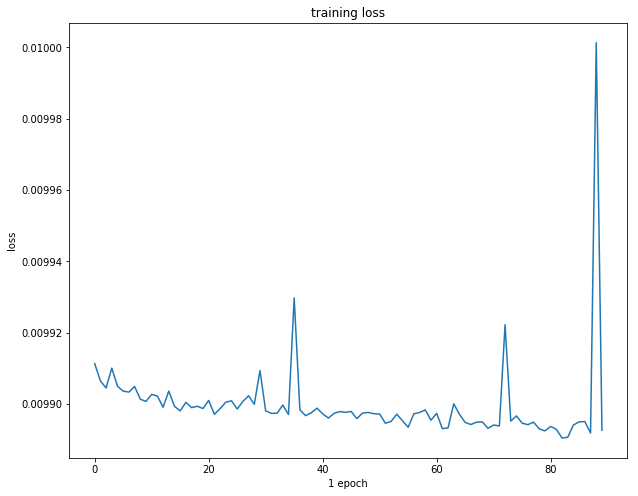

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0153 - val_loss: 0.0099 - val_acc: 0.0021


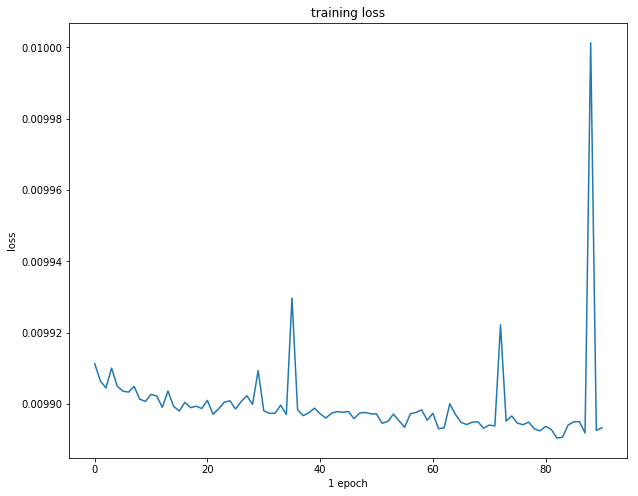

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0163 - val_loss: 0.0099 - val_acc: 0.0121


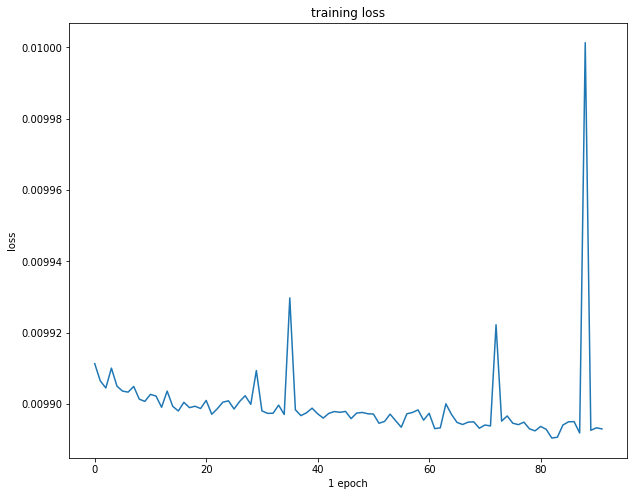

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0153 - val_loss: 0.0099 - val_acc: 0.0036


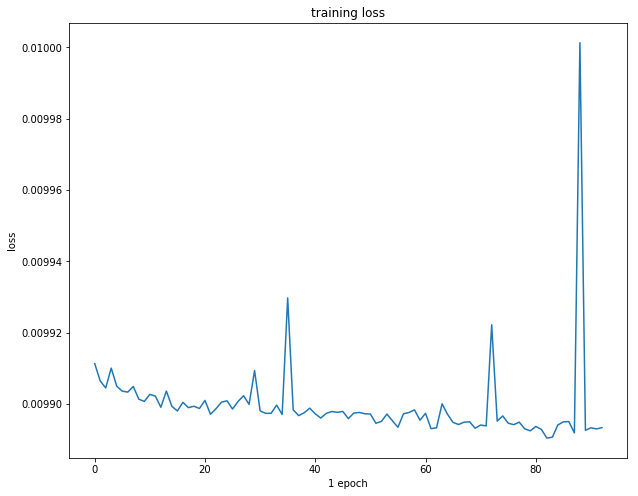

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0159 - val_loss: 0.0099 - val_acc: 0.0071


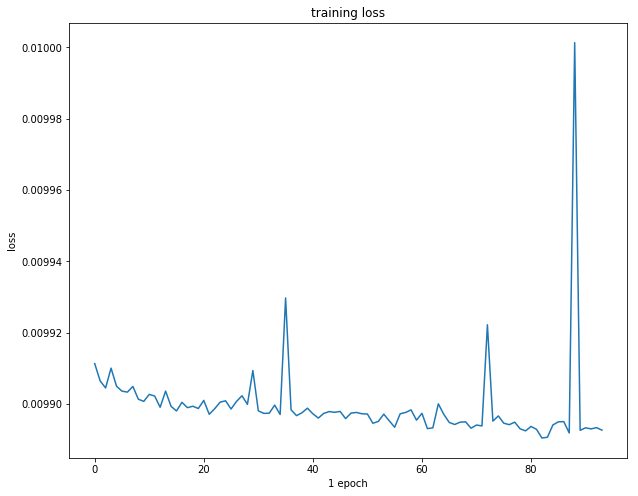

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0148 - val_loss: 0.0099 - val_acc: 0.0057


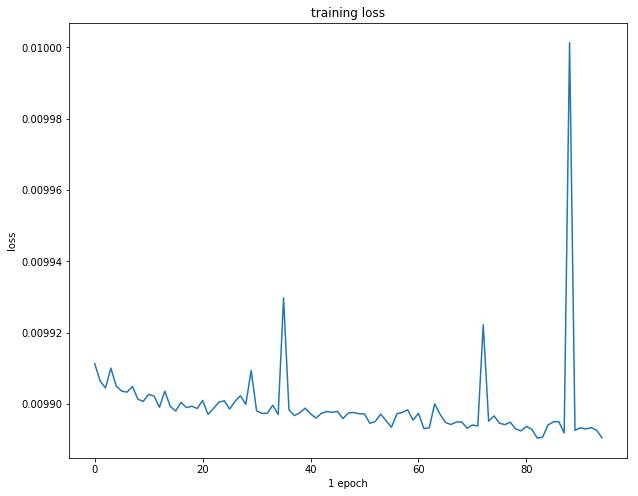

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0166 - val_loss: 0.0099 - val_acc: 0.0099


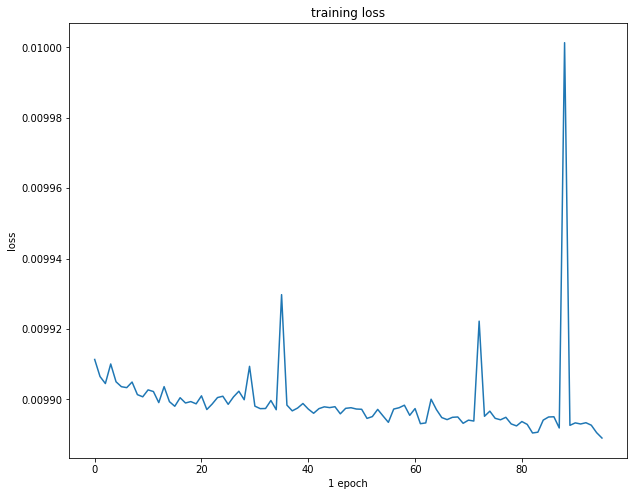

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0183 - val_loss: 0.0099 - val_acc: 0.0064


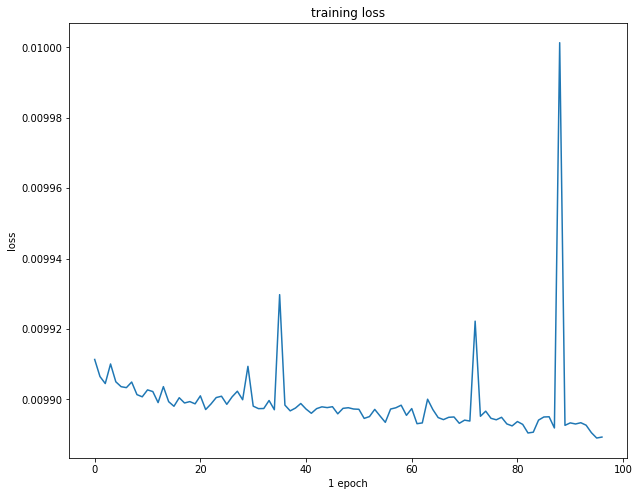

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0150 - val_loss: 0.0099 - val_acc: 0.0114


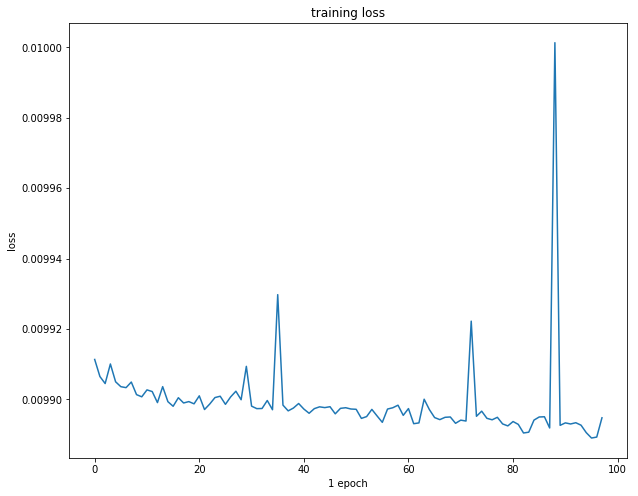

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0167 - val_loss: 0.0099 - val_acc: 0.0128


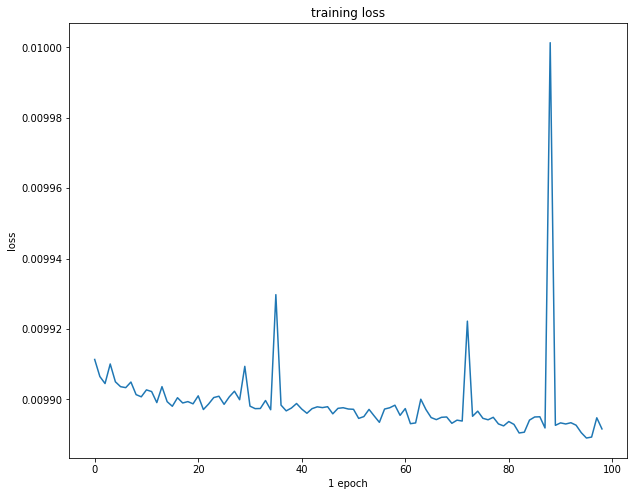

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0161 - val_loss: 0.0099 - val_acc: 0.0050


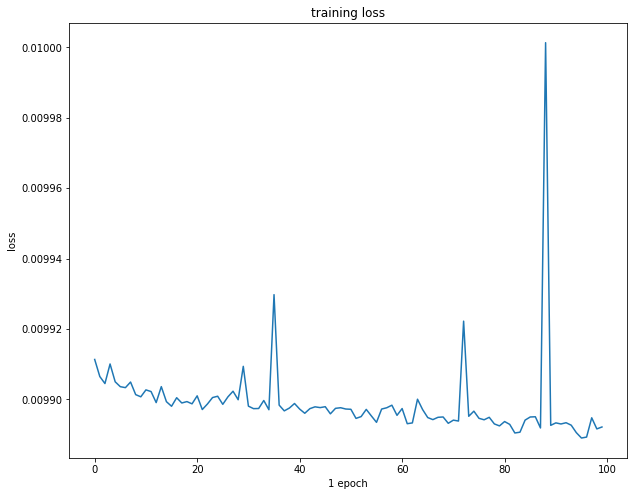

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0183 - val_loss: 0.0099 - val_acc: 0.0050


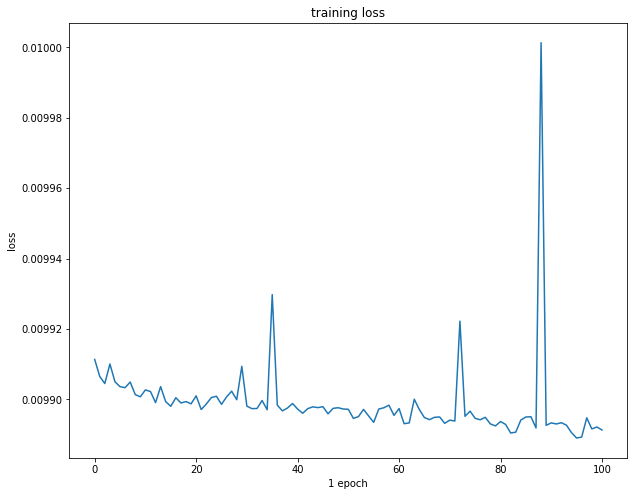

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0166 - val_loss: 0.0100 - val_acc: 0.0107


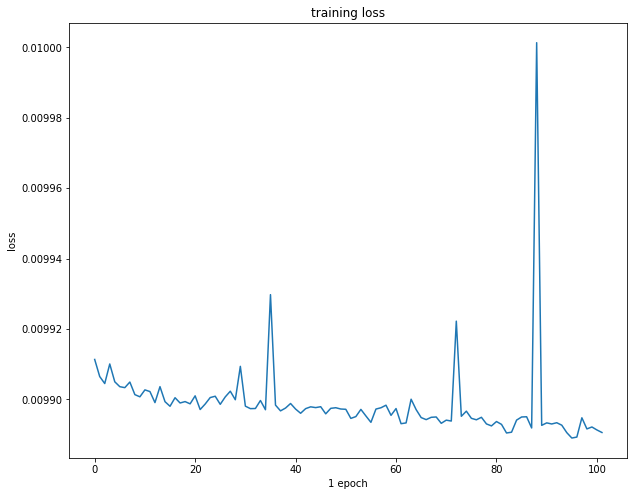

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0186 - val_loss: 0.0099 - val_acc: 0.0085


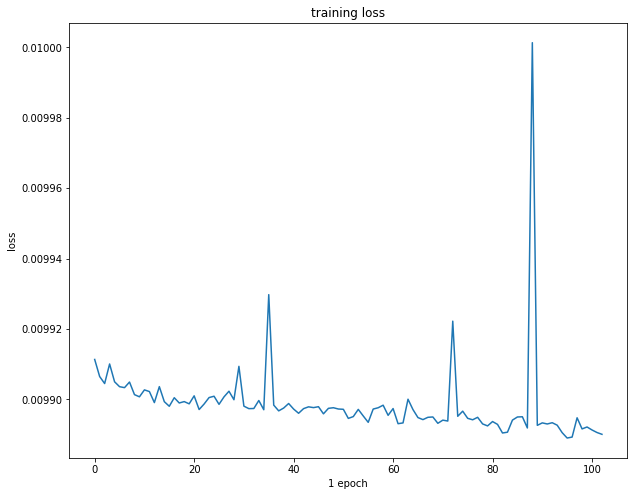

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0150 - val_loss: 0.0099 - val_acc: 0.0021


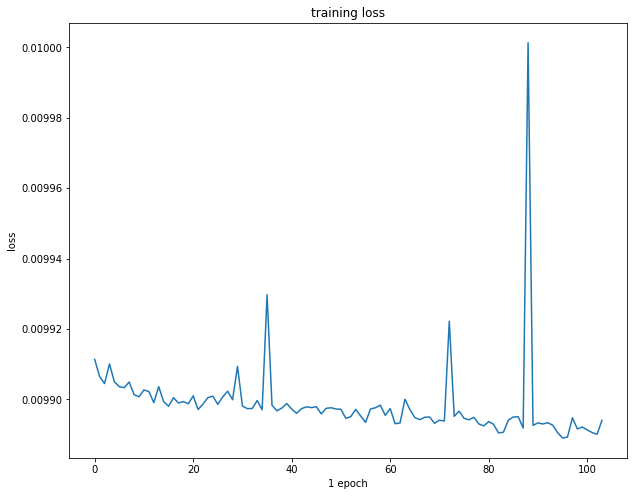

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0139 - val_loss: 0.0100 - val_acc: 0.0107


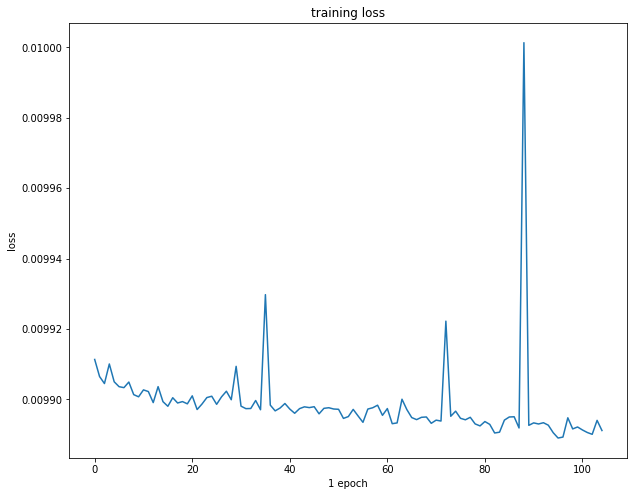

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0152 - val_loss: 0.0100 - val_acc: 0.0043


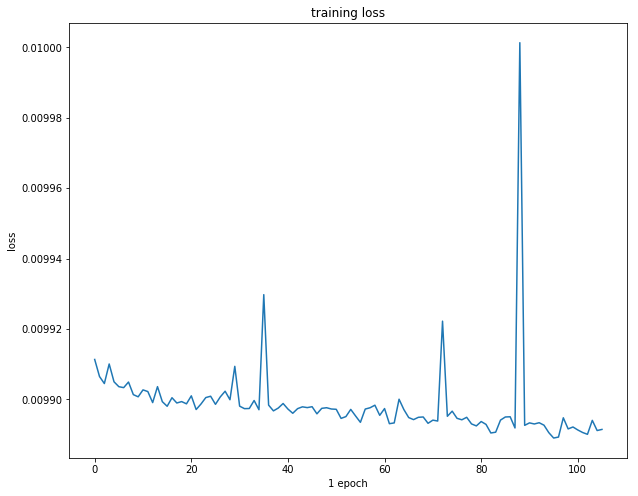

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0142 - val_loss: 0.0099 - val_acc: 7.1023e-04


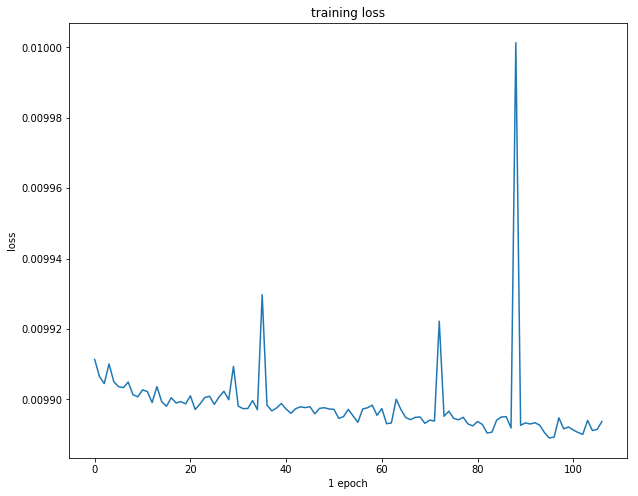

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0161 - val_loss: 0.0099 - val_acc: 0.0036


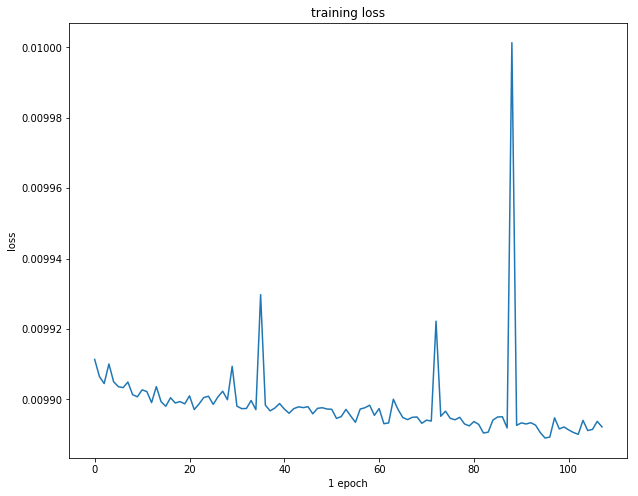

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0194 - val_loss: 0.0099 - val_acc: 0.0071


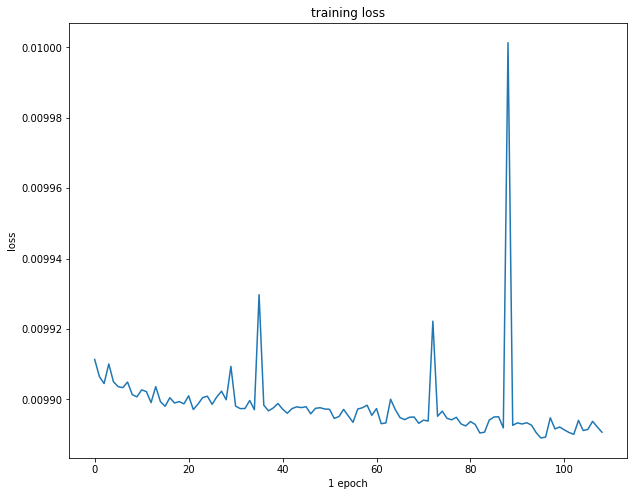

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
88s - loss: 0.0099 - acc: 0.0183 - val_loss: 0.0099 - val_acc: 0.0163


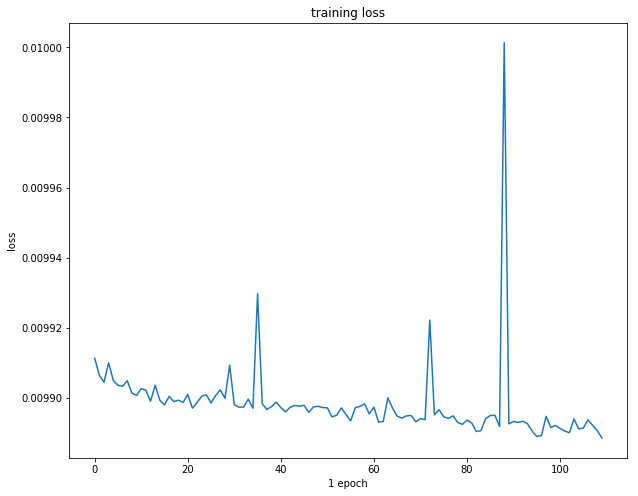

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0161 - val_loss: 0.0099 - val_acc: 0.0107


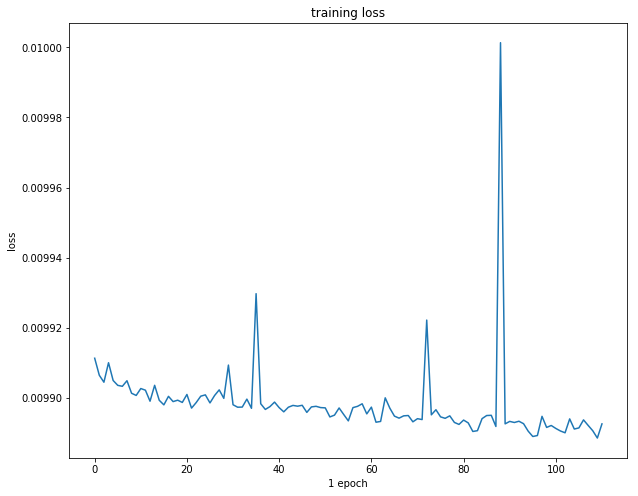

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0197 - val_loss: 0.0099 - val_acc: 0.0078


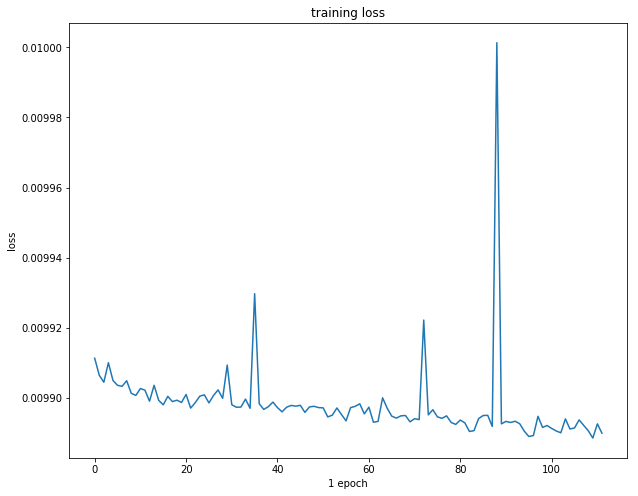

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0170 - val_loss: 0.0099 - val_acc: 0.0163


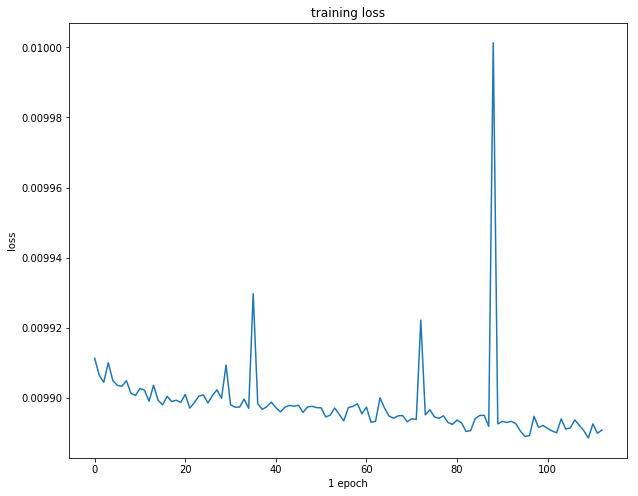

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0141 - val_loss: 0.0099 - val_acc: 0.0036


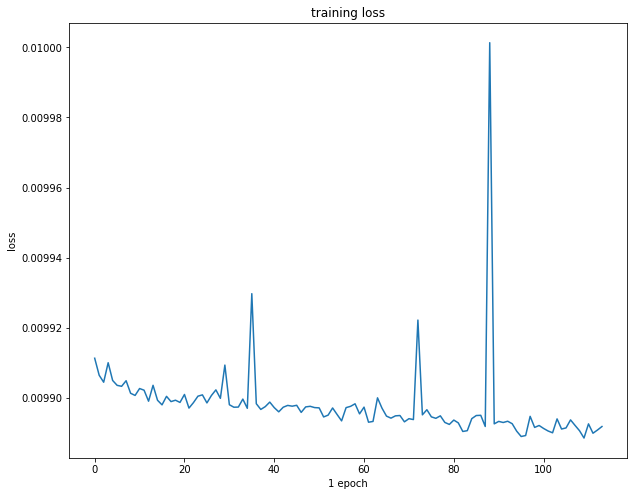

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0183 - val_loss: 0.0099 - val_acc: 0.0057


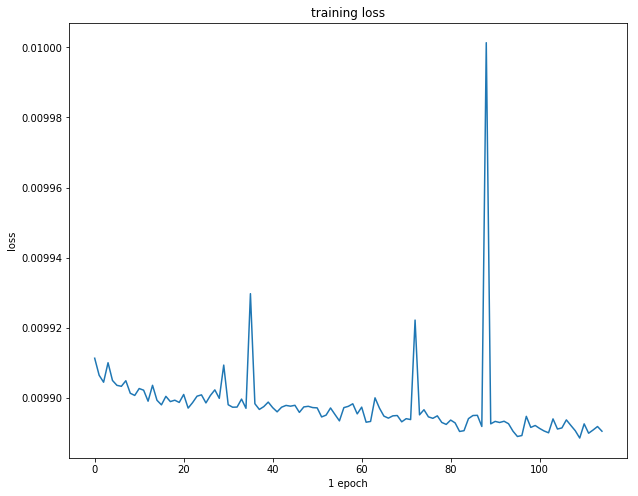

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0156 - val_loss: 0.0100 - val_acc: 0.0107


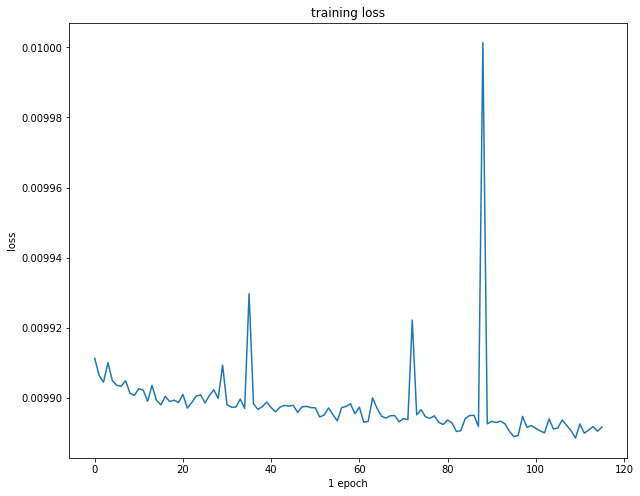

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0158 - val_loss: 0.0099 - val_acc: 0.0071


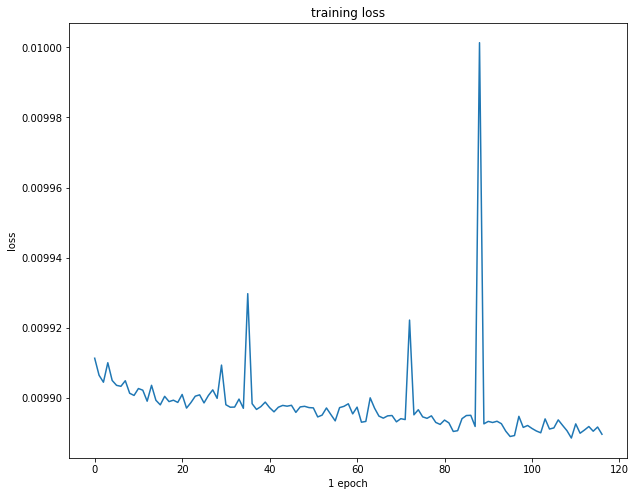

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0169 - val_loss: 0.0099 - val_acc: 7.1023e-04


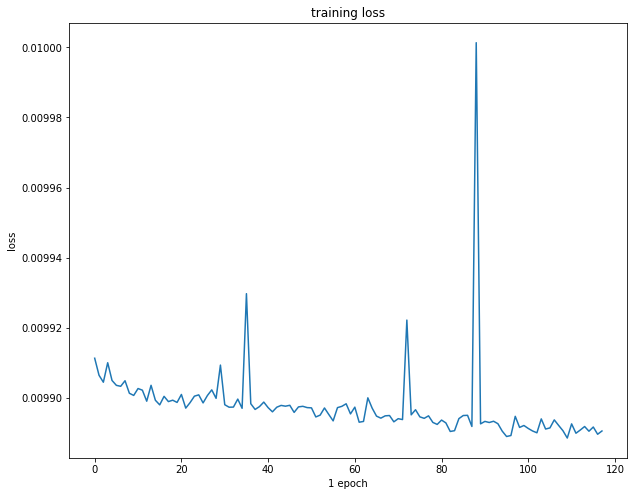

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0203 - val_loss: 0.0099 - val_acc: 0.0036


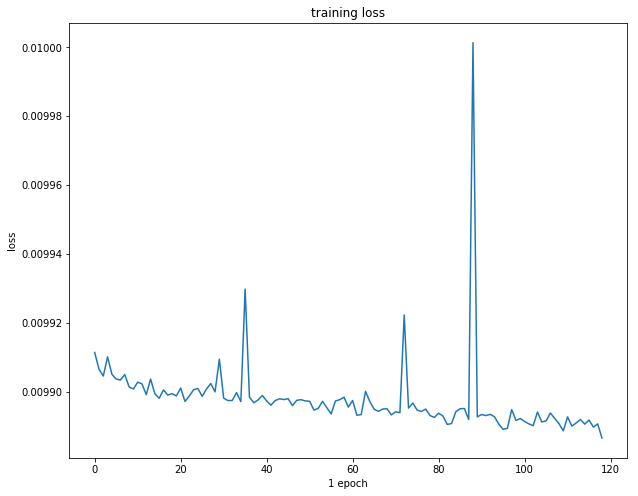

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0183 - val_loss: 0.0099 - val_acc: 0.0064


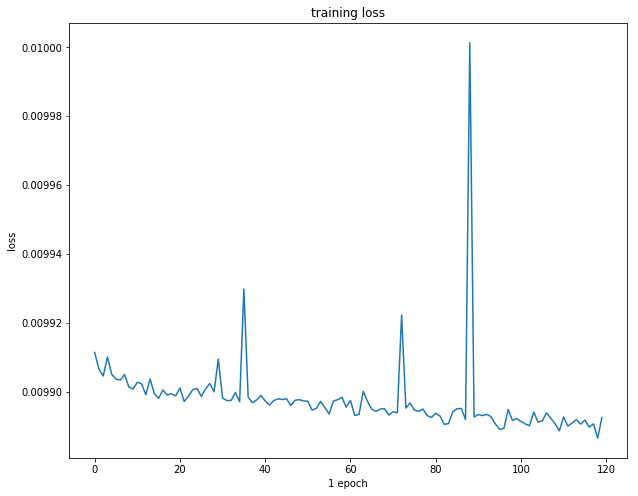

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0184 - val_loss: 0.0099 - val_acc: 0.0085


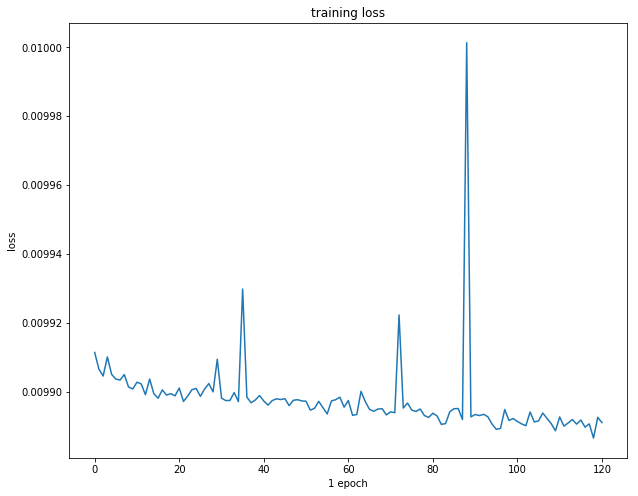

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0175 - val_loss: 0.0099 - val_acc: 0.0107


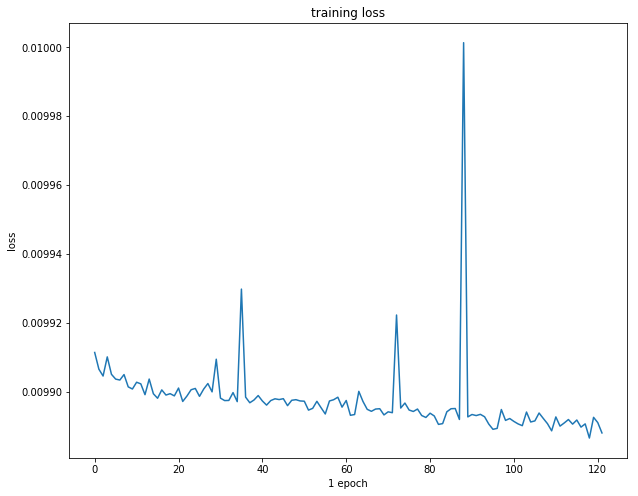

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0141 - val_loss: 0.0099 - val_acc: 0.0021


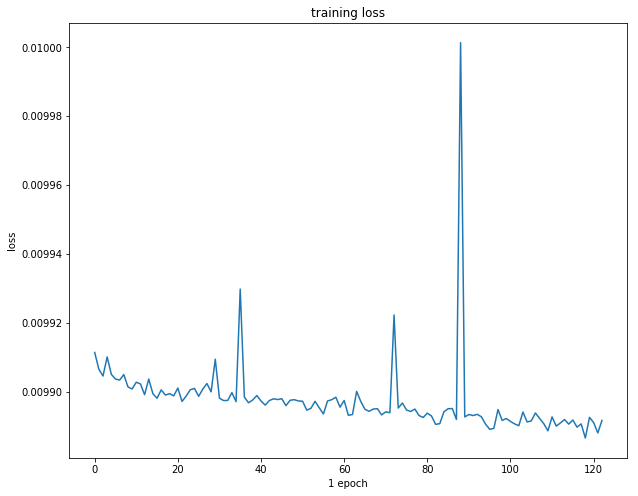

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0169 - val_loss: 0.0099 - val_acc: 0.0021


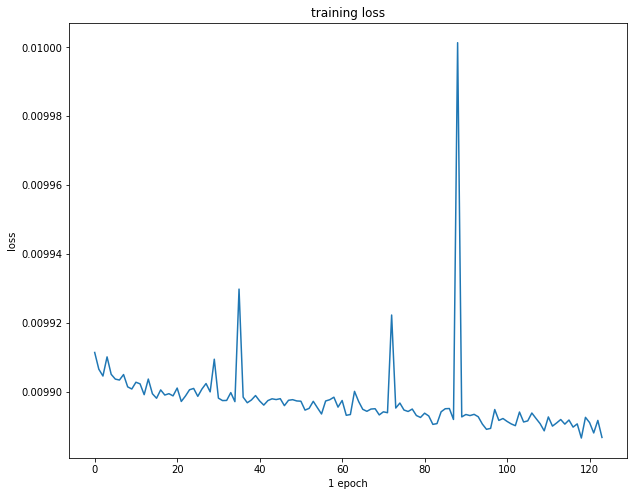

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0163 - val_loss: 0.0099 - val_acc: 0.0050


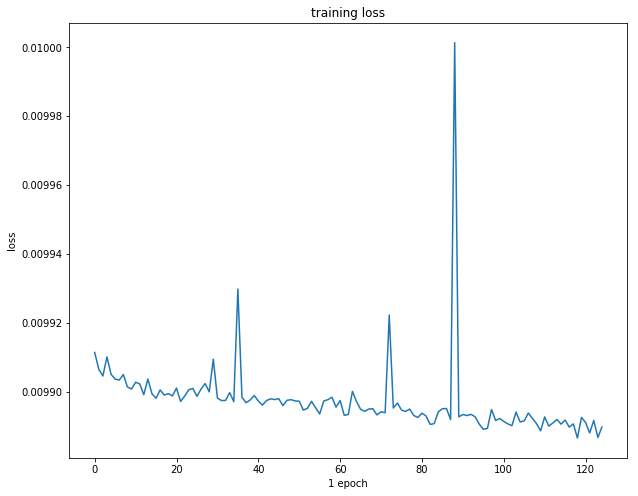

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0178 - val_loss: 0.0099 - val_acc: 0.0099


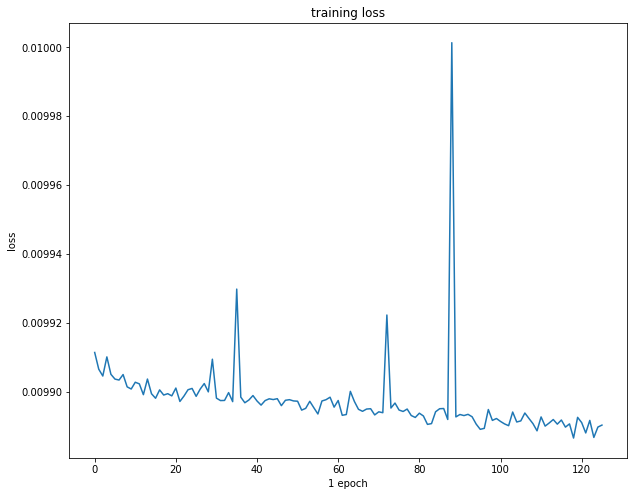

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0172 - val_loss: 0.0099 - val_acc: 0.0043


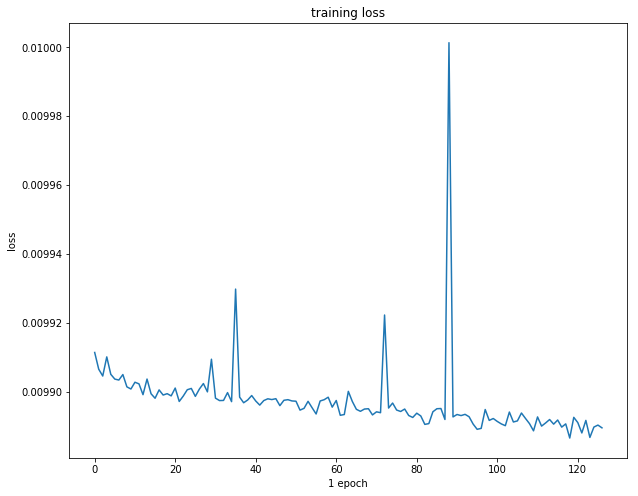

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0172 - val_loss: 0.0099 - val_acc: 0.0000e+00


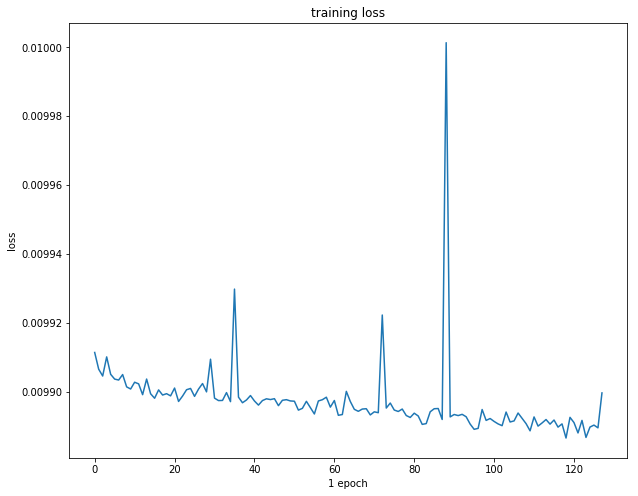

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0178 - val_loss: 0.0099 - val_acc: 0.0043


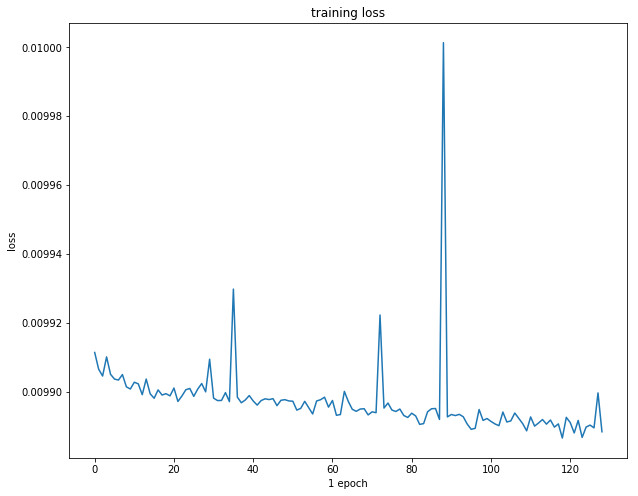

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0205 - val_loss: 0.0099 - val_acc: 0.0036


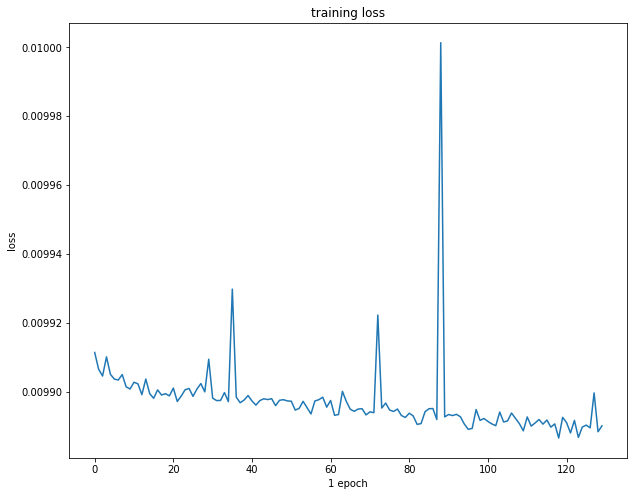

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0181 - val_loss: 0.0099 - val_acc: 0.0078


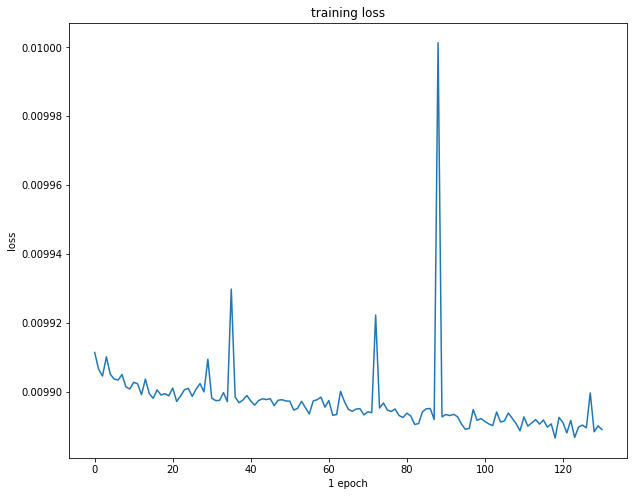

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0180 - val_loss: 0.0099 - val_acc: 0.0036


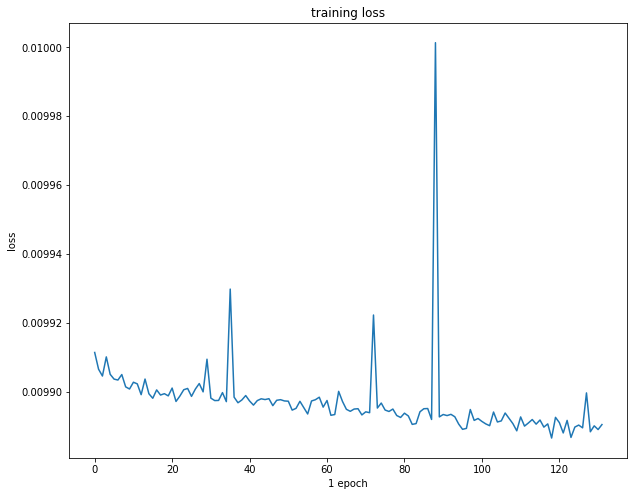

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0164 - val_loss: 0.0099 - val_acc: 0.0163


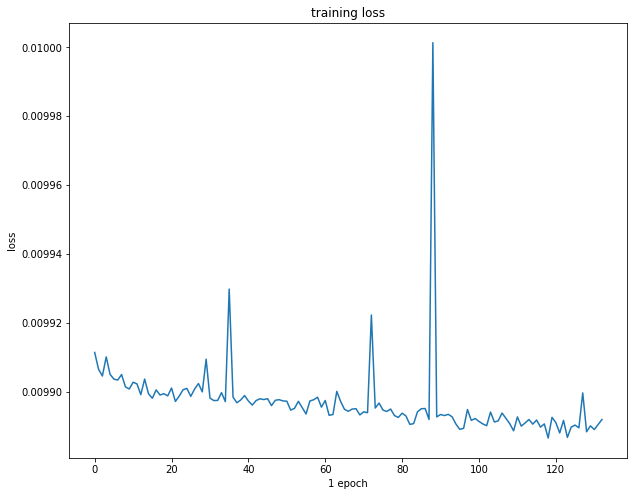

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0166 - val_loss: 0.0099 - val_acc: 0.0121


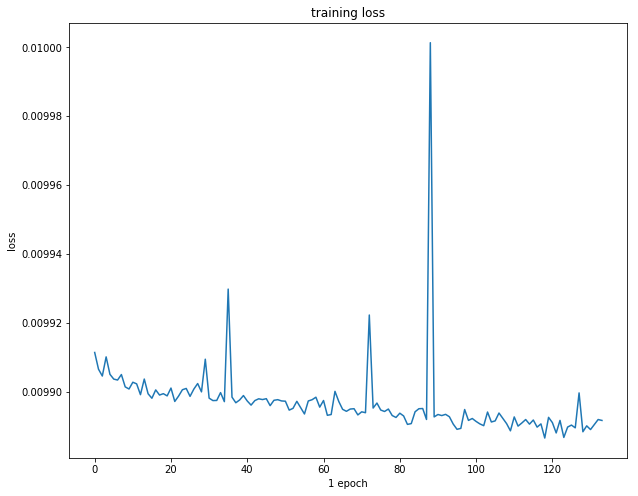

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0228 - val_loss: 0.0099 - val_acc: 0.0021


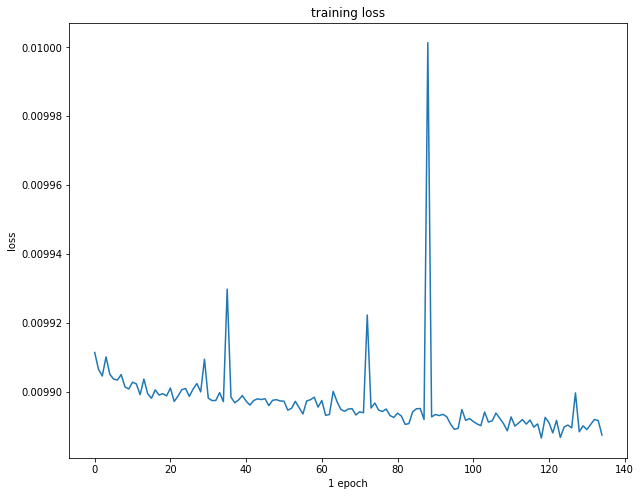

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0156 - val_loss: 0.0099 - val_acc: 0.0064


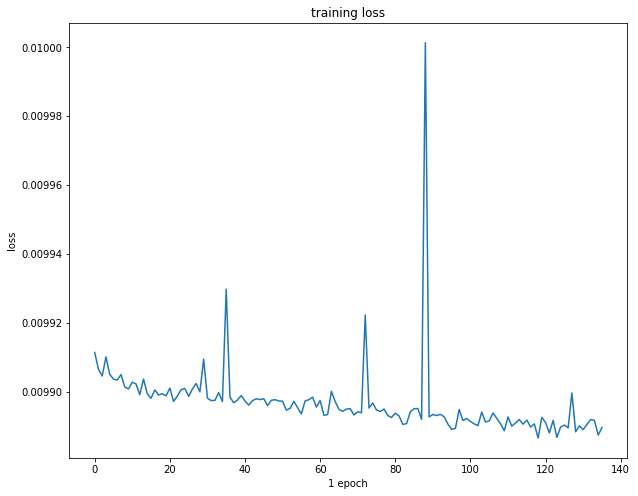

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0205 - val_loss: 0.0099 - val_acc: 7.1023e-04


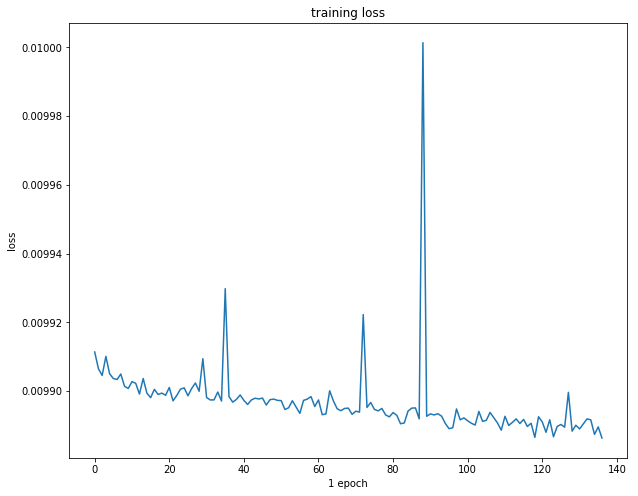

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0169 - val_loss: 0.0099 - val_acc: 0.0092


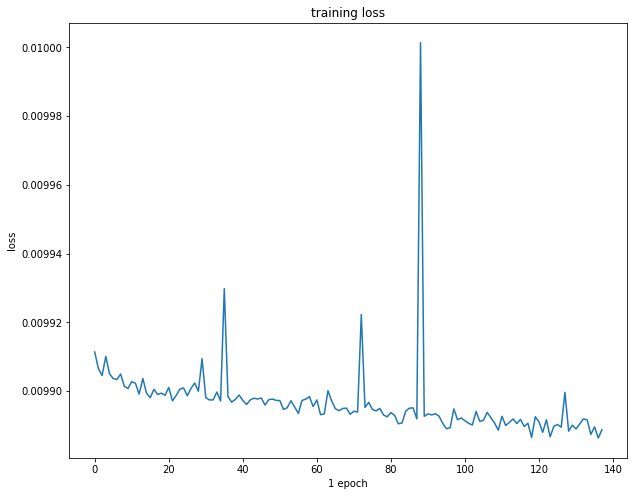

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0156 - val_loss: 0.0099 - val_acc: 0.0021


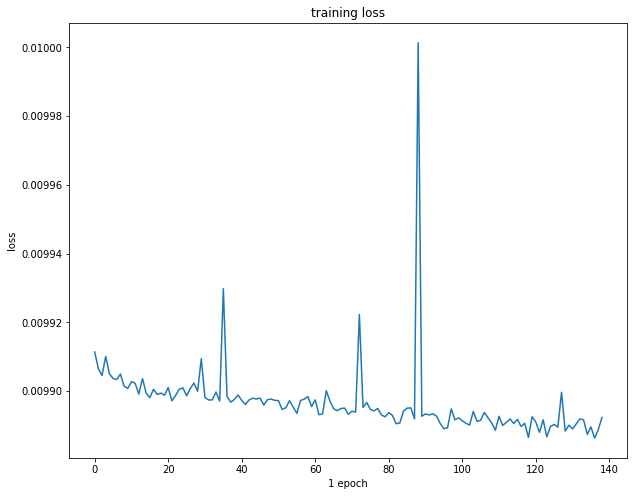

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0192 - val_loss: 0.0099 - val_acc: 0.0057


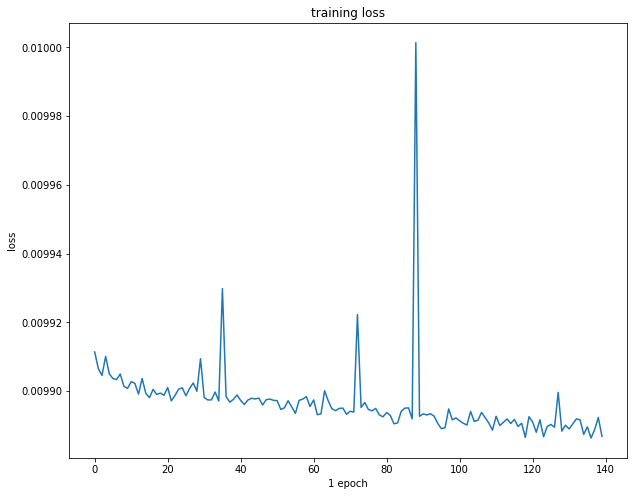

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0152 - val_loss: 0.0099 - val_acc: 0.0057


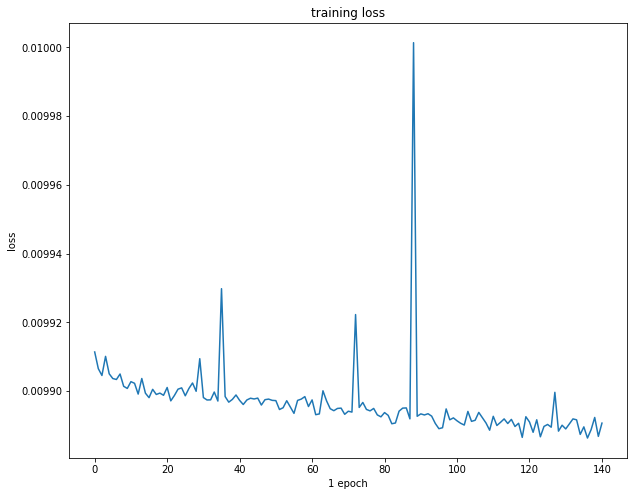

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0167 - val_loss: 0.0099 - val_acc: 0.0057


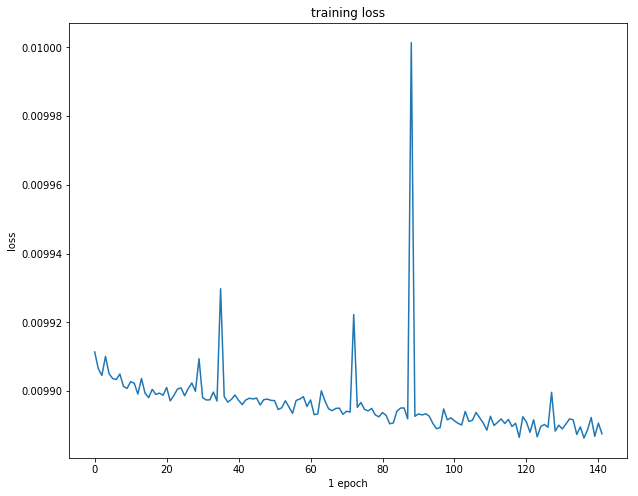

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0167 - val_loss: 0.0099 - val_acc: 0.0092


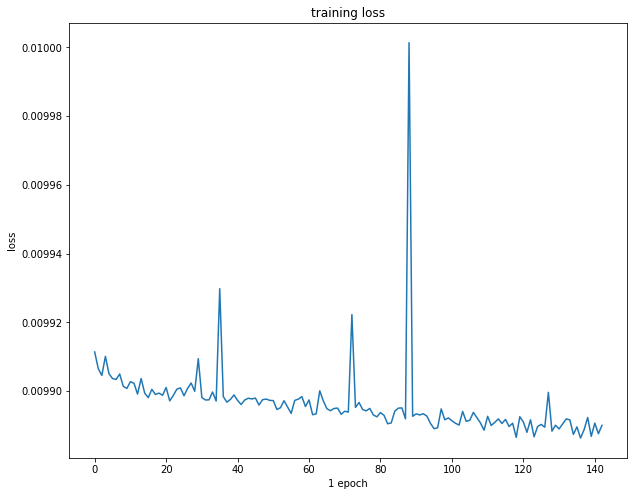

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0177 - val_loss: 0.0099 - val_acc: 0.0092


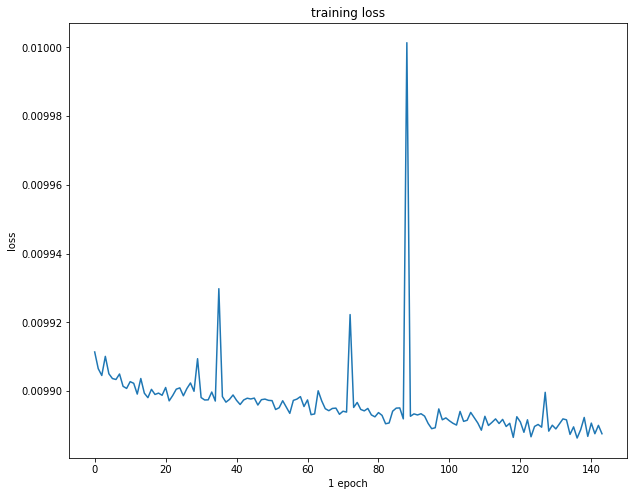

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0181 - val_loss: 0.0099 - val_acc: 0.0078


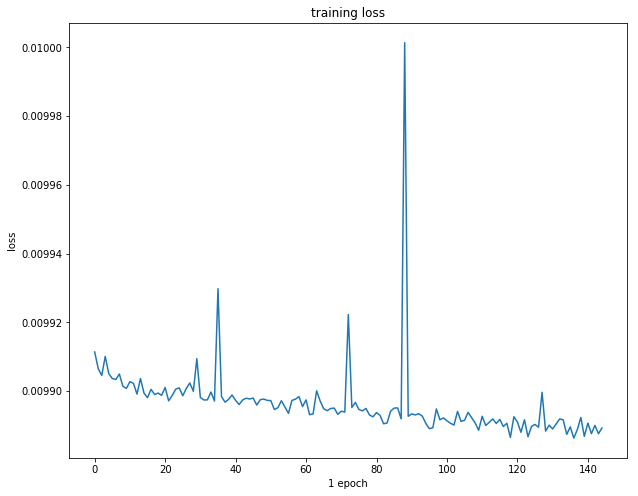

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0197 - val_loss: 0.0099 - val_acc: 0.0057


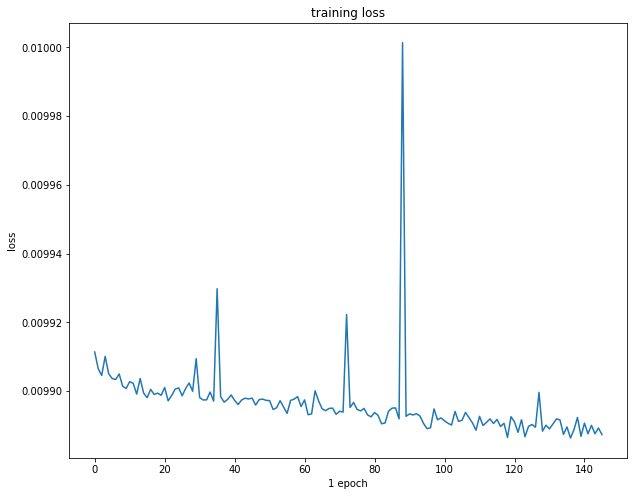

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0169 - val_loss: 0.0099 - val_acc: 0.0085


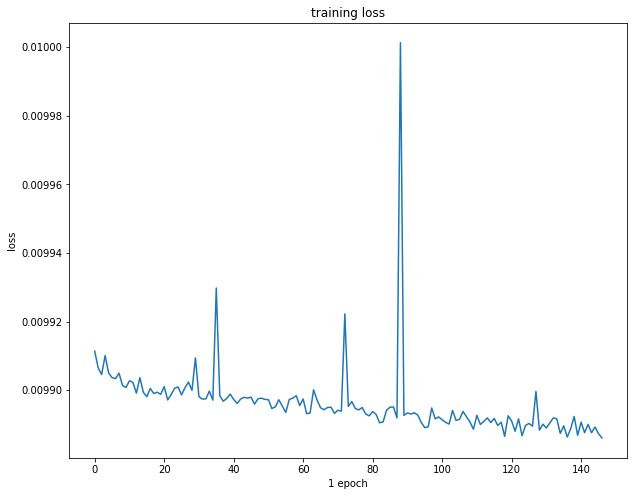

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0175 - val_loss: 0.0099 - val_acc: 0.0064


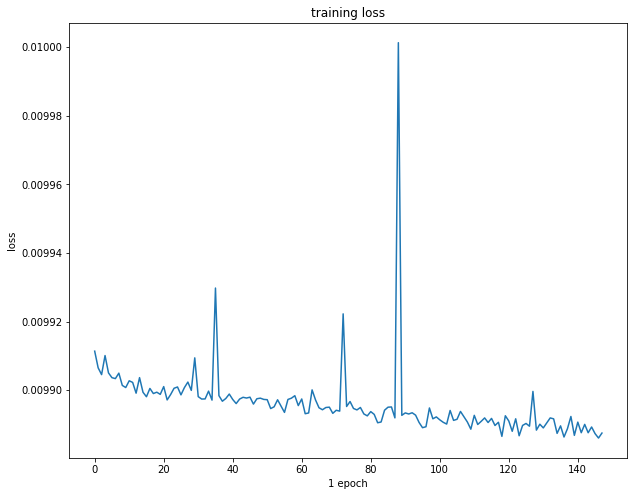

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0161 - val_loss: 0.0099 - val_acc: 0.0028


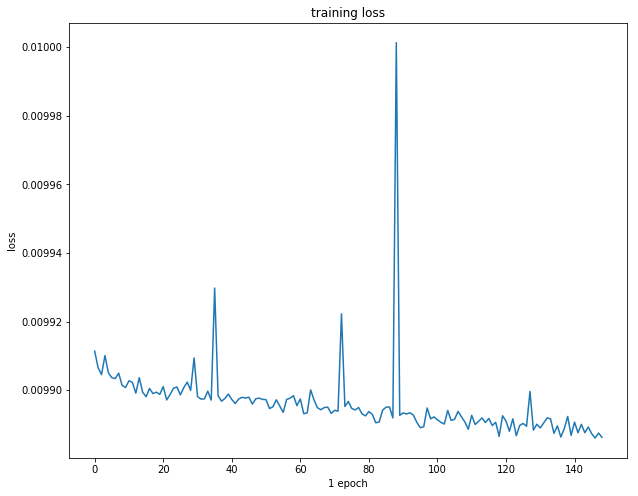

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0164 - val_loss: 0.0099 - val_acc: 0.0099


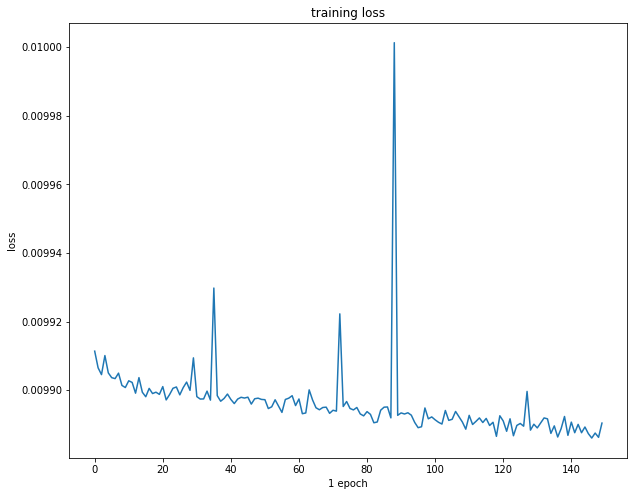

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0180 - val_loss: 0.0099 - val_acc: 0.0057


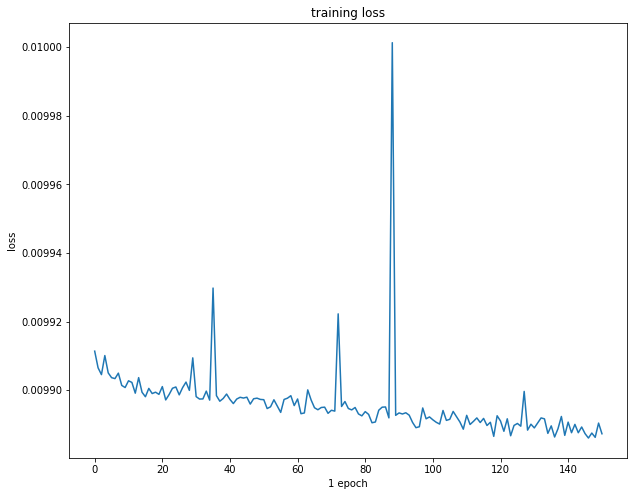

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0191 - val_loss: 0.0099 - val_acc: 0.0071


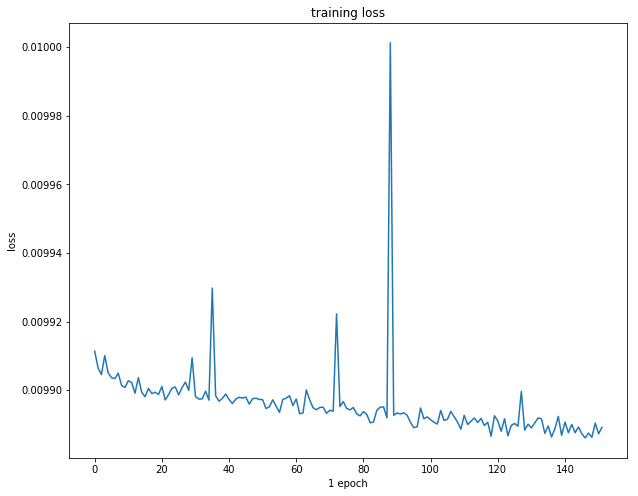

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0164 - val_loss: 0.0099 - val_acc: 0.0064


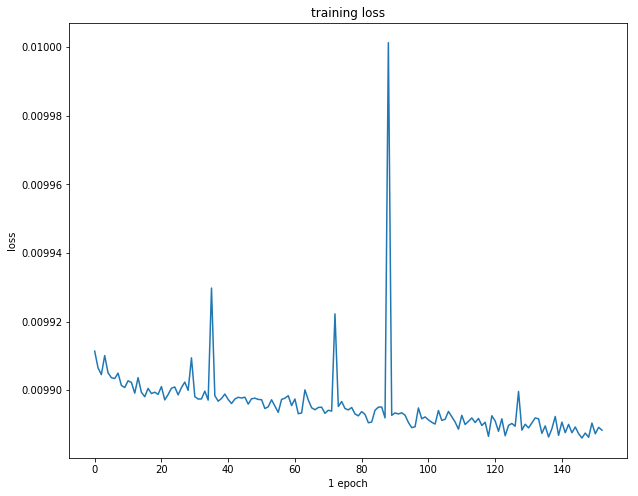

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0211 - val_loss: 0.0099 - val_acc: 0.0064


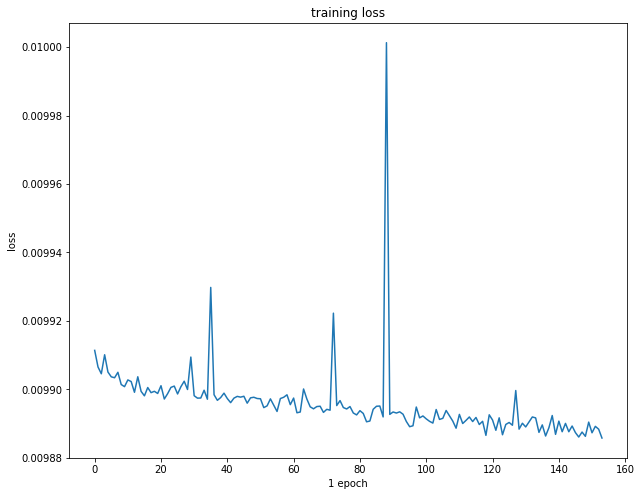

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0163 - val_loss: 0.0099 - val_acc: 0.0092


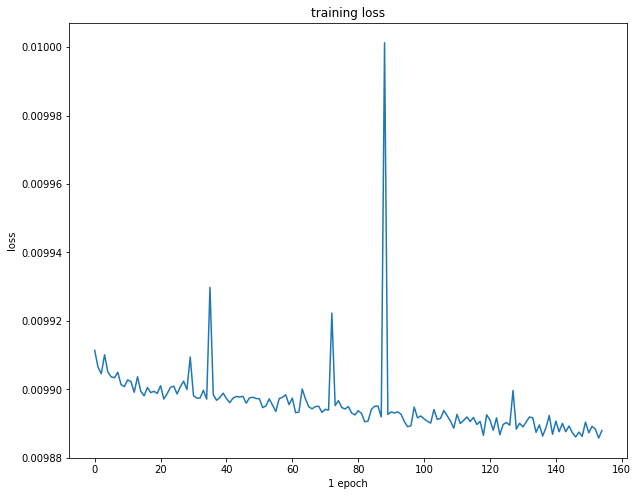

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0192 - val_loss: 0.0099 - val_acc: 0.0057


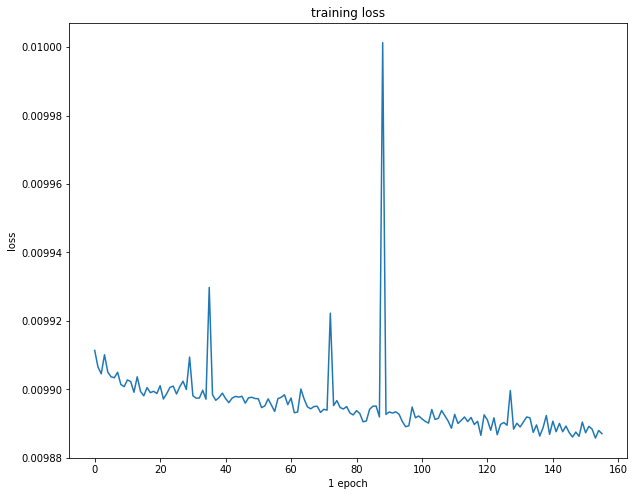

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0158 - val_loss: 0.0099 - val_acc: 0.0043


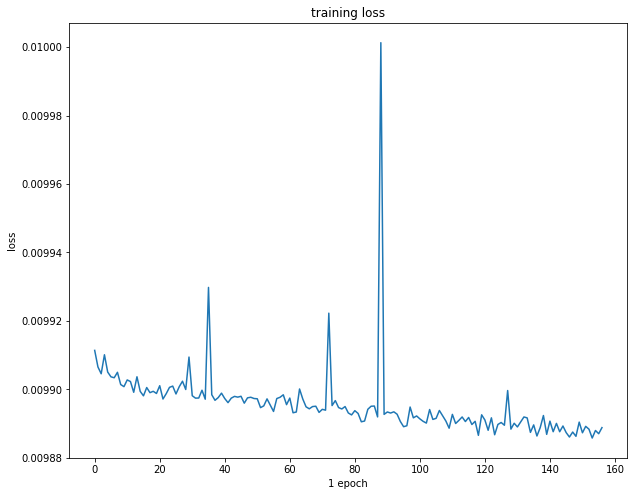

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0187 - val_loss: 0.0099 - val_acc: 0.0028


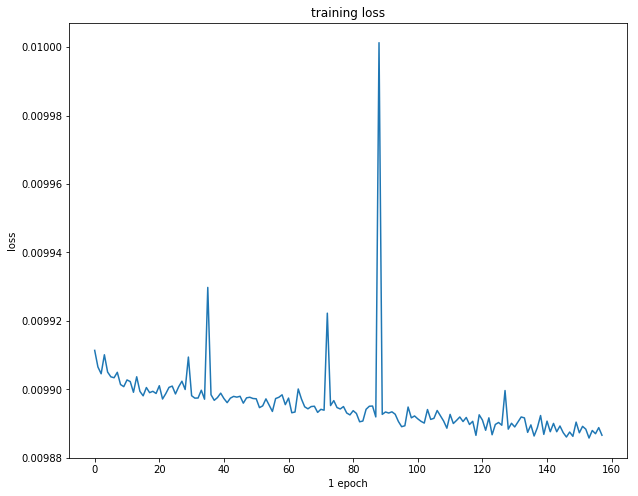

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0170 - val_loss: 0.0099 - val_acc: 0.0071


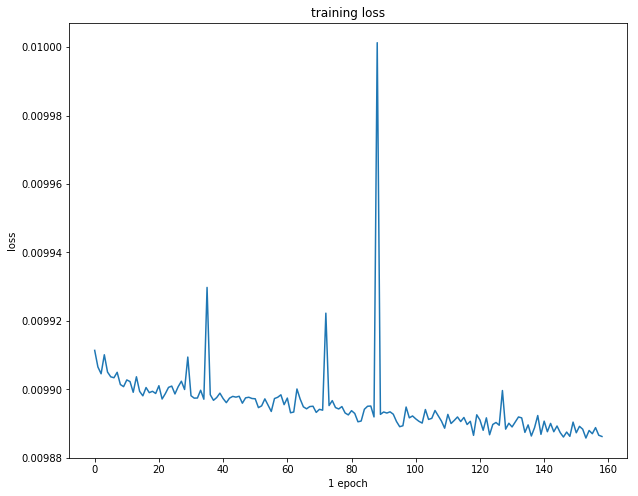

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0194 - val_loss: 0.0100 - val_acc: 0.0014


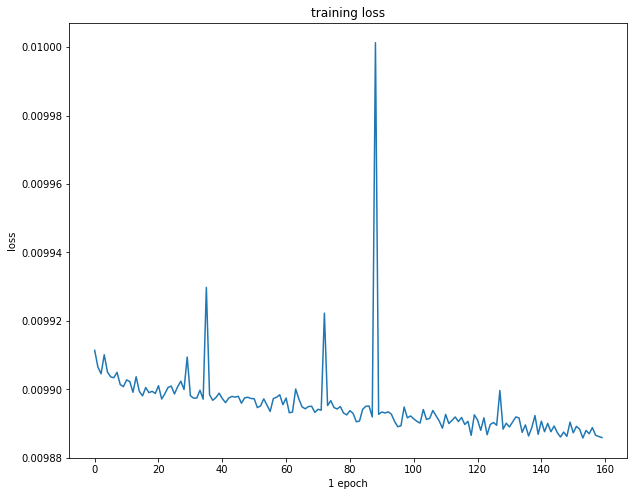

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0202 - val_loss: 0.0100 - val_acc: 0.0071


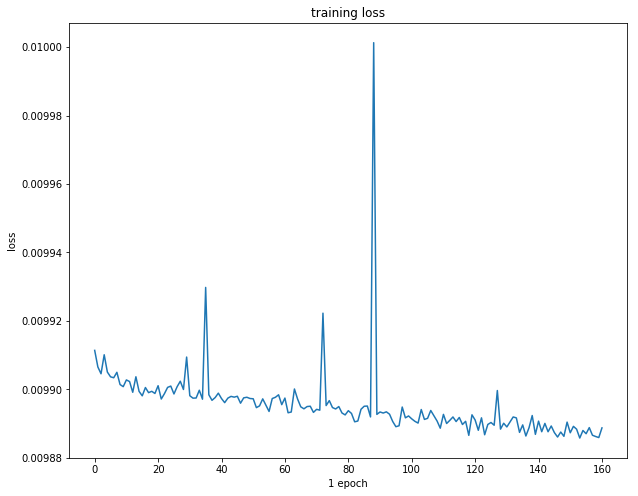

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0180 - val_loss: 0.0099 - val_acc: 0.0050


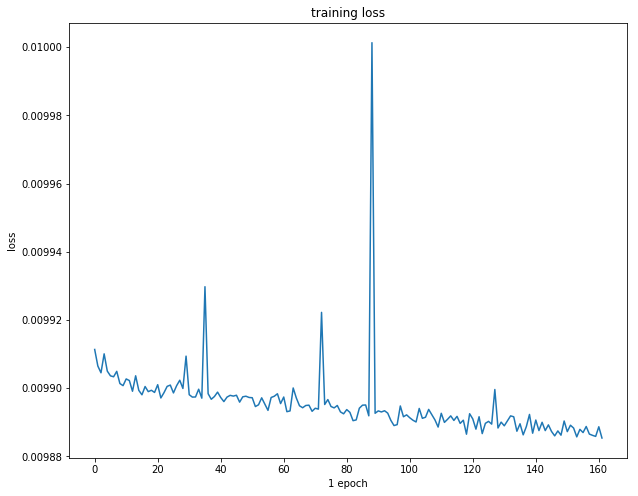

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0173 - val_loss: 0.0099 - val_acc: 0.0142


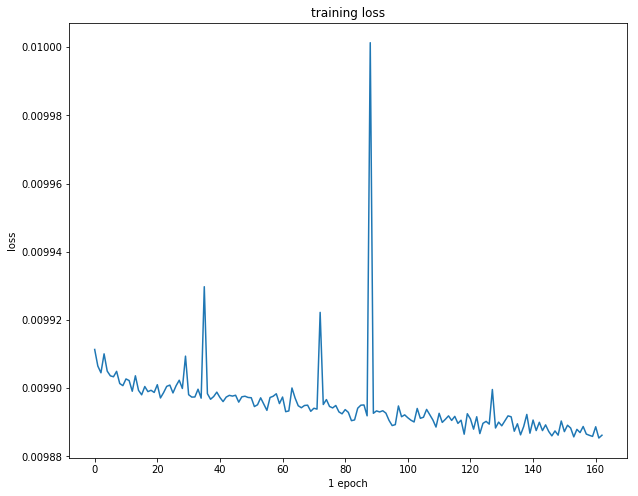

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1
77s - loss: 0.0099 - acc: 0.0147 - val_loss: 0.0099 - val_acc: 0.0014


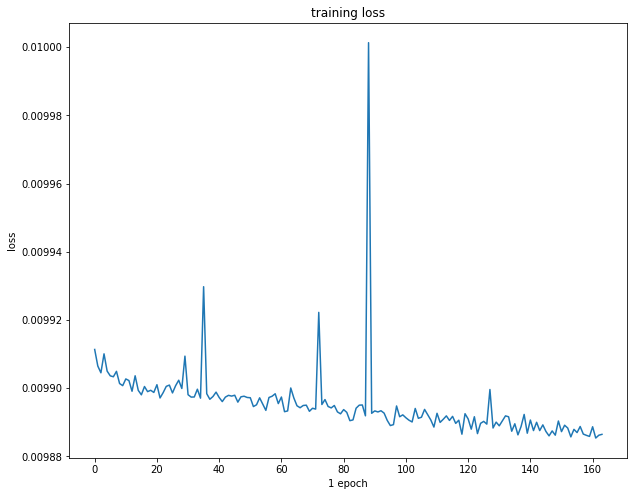

(6400, 10, 100)
(6400, 10, 48, 64, 2)
(1408, 10, 100)
(1408, 10, 48, 64, 2)
Train on 6400 samples, validate on 1408 samples
Epoch 1/1


KeyboardInterrupt: 

In [28]:
losses = np.array([]) # temporary container. fear not, everything goes to log file too
for e in range(epochs):
    #print("Epoch",e, "/",epochs)
    model.reset_states() 
    x_train_imu, x_train_img, y, ind = sample_minibatch(32*200, 10, flag="train") # really, sample epoch
    y_train = y[:,-1,:]
    x_val_imu, x_val_img, y_val, ind = sample_minibatch(32*44, 10, flag="val")
    y_val = y_val[:,-1,:]
    hist_callback = model.fit(x=[x_train_img, x_train_imu], y=y_train, validation_data=([x_val_img, x_val_imu], y_val), verbose=2, batch_size=32,callbacks=[csv_logger, chkpt], shuffle=True)
    losses = np.append(losses, hist_callback.history['loss'])
    # save state here
    plt.figure()
    plt.plot(losses)
    plt.title('training loss')
    plt.xlabel('1 epoch')
    plt.ylabel('loss')
    plt.show()
    

In [62]:
data = np.genfromtxt(filename, delimiter=',', skip_header=1, names=['epoch','loss'])

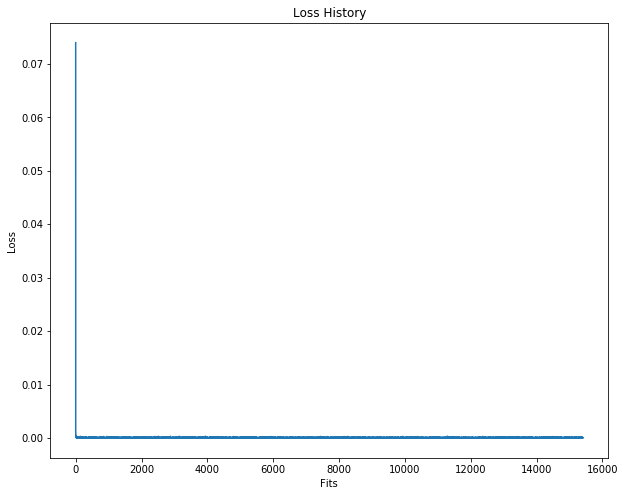

In [63]:
plt.plot(data['loss'])
plt.title("Loss History")
plt.xlabel("Fits")
plt.ylabel("Loss")

In [ ]:
model.predict()

In [39]:
int(N_training/32)

205